# Machine Learning - Ensemble Models
- 여러 예측 모델을 연결하여 더 강력한 모델을 만드는 것
- 편향, 잡음 및 분산으로 인한 오류를 막고, Overfitting 방지

In [ ]:
import warnings, platform
import matplotlib.pyplot as plt

from IPython.display import display, HTML

In [ ]:
### HTML display 조정
display(HTML("<style>.container {width :98% !important;}</style>"))

### Warning 제거
warnings.filterwarnings('ignore')

In [4]:
### 한글 폰트 설정
if platform.system()=='Darwin':
    plt.rc('font', family='AppleGothic')
elif platform.system()=='Linux':
    # !wget "https://www.wfonts.com/download/data/2016/06/13/malgun-gothic/malgun.ttf"
    # !mv malgun.ttf /usr/share/fonts/truetype/
    import matplotlib.font_manager as fm
    fm._rebuild()
    plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False # minus 폰트 깨짐 해결

## Package Load

In [1]:
import random

import numpy as np
import pandas as pd

import scipy.stats as stats
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, cross_val_score, cross_validate, cross_val_predict
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error, r2_score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve, roc_curve, RocCurveDisplay, roc_auc_score, auc

from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [3]:
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import PolynomialFeatures

## Bagging
- Bootstrap aggregating
- 크기가 같은 표본을 단순 임의 복원추출하여 여러 개의 모델을 만듦
- Bootstraping -> Modeling -> Voting
- 분산이 적은 모델을 만드는 것이 목표이고, 각 과정은 병렬로 이루어짐
- Pasting: Bagging과 동일 과정을 거치나, 비복원추출 진행하는 것이 다른 점. 성능이 떨어져서 잘 사용하지 않음

### (1) Classifier

In [446]:
breast = pd.read_csv('./ADP_book_ver01/data/breast-cancer.csv')

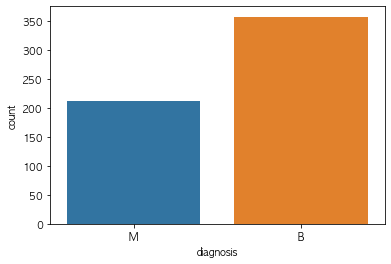

In [447]:
sns.countplot(x='diagnosis', data=breast)
plt.show()

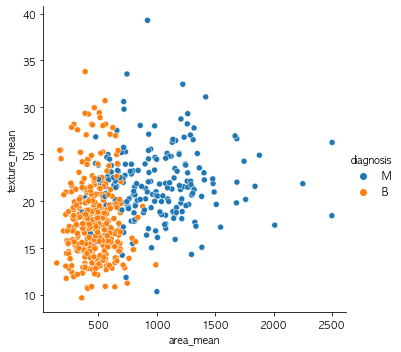

In [448]:
sns.relplot(x='area_mean', y='texture_mean', hue='diagnosis', data=breast)
plt.show()

In [449]:
breast["diagnosis"] = np.where(breast["diagnosis"]=="M", 1, 0) # target 변수 처리
features = ["area_mean", "area_worst"]

x = breast[features]
y = breast["diagnosis"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, stratify=y, random_state=1)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(398, 2) (171, 2) (398,) (171,)


In [450]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

In [451]:
### Modeling
clf = BaggingClassifier(base_estimator=DecisionTreeClassifier())
pred = clf.fit(x_train, y_train).predict(x_test)
print("Accuracy Score : ", clf.score(x_test, pred))

Accuracy Score :  1.0


In [452]:
pd.DataFrame(confusion_matrix(y_test, pred), index=['True[0]', 'True[1]'], columns=['Pred[0]','Pred[1]'])

,Pred[0],Pred[1]
True[0],103,4
True[1],9,55


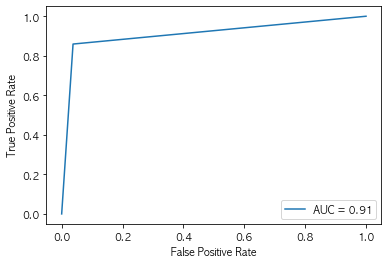

In [453]:
fpr, tpr, thresholds = roc_curve(y_test, pred)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc) # plot_roc_curve(clf, x_test, y_test)
display.plot()
plt.show()

In [454]:
### oob_score
# Out of bag
# Bootstrap 시 선택되지 않은 데이터로 평가한 결과
clf_oob = BaggingClassifier(base_estimator=DecisionTreeClassifier(), oob_score=True)
oob = clf_oob.fit(x, y).oob_score_
print(oob)

0.9191564147627417


In [455]:
### iris data
x = iris.drop('Class', axis=1)
y = iris['Class']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=1)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(80, 4) (20, 4) (80,) (20,)


In [456]:
### Modeling
clf = BaggingClassifier(base_estimator=DecisionTreeClassifier())
pred = clf.fit(x_train, y_train).predict(x_test)
print("Accuracy Score : ", clf.score(x_test, pred))

Accuracy Score :  1.0


In [457]:
pd.DataFrame(confusion_matrix(y_test, pred), index=['True[0]', 'True[1]'], columns=['Pred[0]','Pred[1]'])

,Pred[0],Pred[1]
True[0],10,0
True[1],1,9


In [458]:
### Moons data
x, y = make_moons(n_samples=500, noise=0.30, random_state=42)
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)

In [459]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500, max_samples=100, bootstrap=True, random_state=42)
bag_clf.fit(x_train, y_train)
y_pred = bag_clf.predict(x_test)
print(accuracy_score(y_test, y_pred)) # Bagging accuracy

0.904


In [460]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(x_train, y_train)
y_pred_tree = tree_clf.predict(x_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


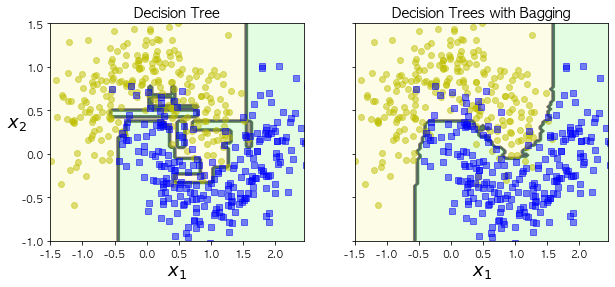

In [461]:
fig, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)

plt.sca(axes[0])
x1s = np.linspace(-1.5, 2.45, 100)
x2s = np.linspace(-1, 1.5, 100)
x1, x2 = np.meshgrid(x1s, x2s)
x_new = np.c_[x1.ravel(), x2.ravel()]
y_pred = tree_clf.predict(x_new).reshape(x1.shape)
custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)

plt.plot(x[:, 0][y==0], x[:, 1][y==0], "yo", alpha=0.5)
plt.plot(x[:, 0][y==1], x[:, 1][y==1], "bs", alpha=0.5)
plt.axis([-1.5, 2.45, -1, 1.5])
plt.xlabel(r"$x_1$", fontsize=18)
plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
plt.title("Decision Tree", fontsize=14)

plt.sca(axes[1])
y_pred = bag_clf.predict(x_new).reshape(x1.shape)
custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)

plt.plot(x[:, 0][y==0], x[:, 1][y==0], "yo", alpha=0.5)
plt.plot(x[:, 0][y==1], x[:, 1][y==1], "bs", alpha=0.5)
plt.axis([-1.5, 2.45, -1, 1.5])
plt.xlabel(r"$x_1$", fontsize=18)
plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
plt.title("Decision Trees with Bagging", fontsize=14)

plt.ylabel("")
plt.show()

In [462]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500, bootstrap=True, oob_score=True, random_state=40) # oob_score option 활성화
bag_clf.fit(x_train, y_train)
bag_clf.oob_score_

0.8986666666666666

In [463]:
bag_clf.oob_decision_function_[:10]

array([[0.32275132, 0.67724868],
       [0.34117647, 0.65882353],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.09497207, 0.90502793],
       [0.31147541, 0.68852459],
       [0.01754386, 0.98245614],
       [0.97109827, 0.02890173],
       [0.97765363, 0.02234637]])

In [464]:
y_pred = bag_clf.predict(x_test)
accuracy_score(y_test, y_pred)

0.912

### (2) Regressor

In [465]:
car = pd.read_csv('./ADP_book_ver01/data/CarPrice_Assignment.csv')
car.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   car_ID            205 non-null    int64  
 1   symboling         205 non-null    int64  
 2   CarName           205 non-null    object 
 3   fueltype          205 non-null    object 
 4   aspiration        205 non-null    object 
 5   doornumber        205 non-null    object 
 6   carbody           205 non-null    object 
 7   drivewheel        205 non-null    object 
 8   enginelocation    205 non-null    object 
 9   wheelbase         205 non-null    float64
 10  carlength         205 non-null    float64
 11  carwidth          205 non-null    float64
 12  carheight         205 non-null    float64
 13  curbweight        205 non-null    int64  
 14  enginetype        205 non-null    object 
 15  cylindernumber    205 non-null    object 
 16  enginesize        205 non-null    int64  
 1

In [466]:
car_num = car.select_dtypes(['number'])
features = list(car_num.columns.difference(['car_ID', 'symboling', 'price']))
x = car_num[features]
y = car_num['price']
print(x.shape, y.shape)

(205, 13) (205,)


In [467]:
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor

In [468]:
reg = BaggingRegressor(base_estimator=DecisionTreeRegressor(), oob_score=True)
reg = reg.fit(x, y)
reg.oob_score_

0.8859047952850826

## Boosting
- Bootstrap 샘플링 과정에서, 분류가 잘못된 데이터의 가중치를 높임
- 예측력이 약한 모델을 결합에 강한 예측모형을 만드는 것
- Overfitting 위험 있음

### (1) AdaBoost

#### Classifier

In [469]:
features = ["area_mean", "texture_mean"]

x = breast[features]
y = breast["diagnosis"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, stratify=y, random_state=1)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(398, 2) (171, 2) (398,) (171,)


In [470]:
from sklearn.ensemble import AdaBoostClassifier

In [471]:
clf = AdaBoostClassifier(base_estimator=None)
pred = clf.fit(x_train, y_train).predict(x_test)
print("정확도 : ", clf.score(x_test, y_test))

정확도 :  0.9122807017543859


In [472]:
pred = clf.predict(x_test)
test_cm = confusion_matrix(y_test, pred)
test_acc = accuracy_score(y_test, pred)
test_prc = precision_score(y_test, pred)
test_rcll = recall_score(y_test, pred)
test_f1 = f1_score(y_test, pred)

print(test_cm)
print('정확도\t{}%'.format(round(test_acc * 100, 2)))
print('정밀도\t{}%'.format(round(test_prc * 100, 2)))
print('재현율\t{}%'.format(round(test_rcll * 100, 2)))
print('F1\t{}%'.format(round(test_f1 * 100, 2)))

[[102   5]
 [ 10  54]]
정확도	91.23%
정밀도	91.53%
재현율	84.38%
F1	87.8%


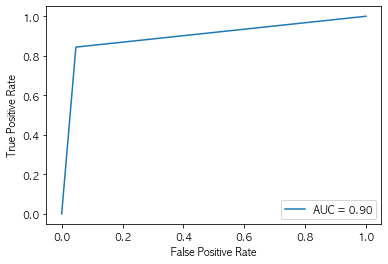

In [473]:
fpr, tpr, thresholds = roc_curve(y_test, pred)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc) # plot_roc_curve(clf, x_test, y_test)
display.plot()
plt.show()

In [474]:
importances = clf.feature_importances_
column_nm = pd.DataFrame(["area_mean", "texture_mean"])
feature_importances = pd.concat([column_nm, pd.DataFrame(importances)], axis=1)
feature_importances.columns = ['feature_nm', 'importances']
print(feature_importances)

     feature_nm  importances
0     area_mean         0.56
1  texture_mean         0.44


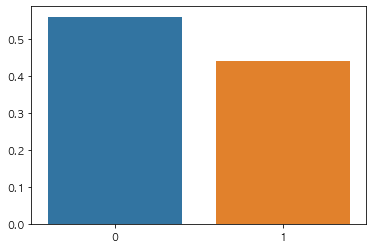

In [475]:
xtick_label_position = list(range(len(features)))
plt.xticks(xtick_label_position, features)
sns.barplot([x for x in range(len(importances))], importances)
plt.show()

In [476]:
### iris data
x = iris.drop('Class', axis=1)
y = iris['Class']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=1)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(80, 4) (20, 4) (80,) (20,)


In [477]:
clf = AdaBoostClassifier(base_estimator=None)
pred = clf.fit(x_train, y_train).predict(x_test)
print("정확도 : ", clf.score(x_test, y_test))

정확도 :  0.95


In [478]:
pred = clf.predict(x_test)
test_cm = confusion_matrix(y_test, pred)
test_acc = accuracy_score(y_test, pred)

print(test_cm)
print('정확도\t{}%'.format(round(test_acc * 100, 2)))

[[10  0]
 [ 1  9]]
정확도	95.0%


In [479]:
clf.feature_importances_

array([0.16, 0.26, 0.18, 0.4 ])

#### Regressor

In [480]:
car_num = car.select_dtypes(['number'])
features = list(car_num.columns.difference(['car_ID', 'symboling', 'price']))

x = car_num[features]
y = car_num['price']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(143, 13) (62, 13) (143,) (62,)


In [481]:
from sklearn.ensemble import AdaBoostRegressor

In [482]:
reg = AdaBoostRegressor(base_estimator=None)
pred = reg.fit(x_train, y_train).predict(x_test)

mse = mean_squared_error(y_test, pred)
mae = mean_absolute_error(y_test, pred)
rmse = np.sqrt(mse)
acc = reg.score(x_test, y_test)

print('MSE\t{}'.format(round(mse, 3)))
print('MAE\t{}'.format(round(mae, 3)))
print('RMSE\t{}'.format(round(rmse, 3)))
print('ACC\t{}%'.format(round(acc * 100, 3)))

MSE	5794172.428
MAE	1806.091
RMSE	2407.109
ACC	90.402%


In [483]:
importances = reg.feature_importances_
column_nm = pd.DataFrame(features)
feature_importances = pd.concat([column_nm, pd.DataFrame(importances)], axis=1)
feature_importances.columns = ['feature_nm', 'importances']
print(feature_importances)

          feature_nm  importances
0          boreratio     0.011453
1          carheight     0.004992
2          carlength     0.006395
3           carwidth     0.065532
4            citympg     0.007420
5   compressionratio     0.003485
6         curbweight     0.073641
7         enginesize     0.636674
8         highwaympg     0.059167
9         horsepower     0.087963
10           peakrpm     0.007369
11            stroke     0.008376
12         wheelbase     0.027531


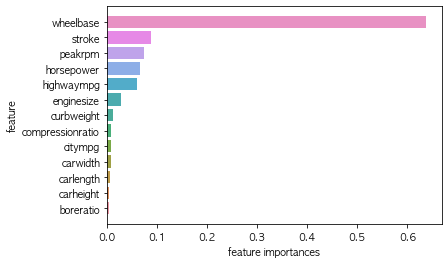

In [484]:
n_features = x_train.shape[1]
importances = pd.Series(reg.feature_importances_, index=x_train.columns).sort_values()

sns.barplot(x=importances, y=features)
plt.yticks(np.arange(n_features), features)
plt.xlabel("feature importances")
plt.ylabel("feature")
plt.ylim(-1, n_features)
plt.show()

### (2) Gradient Boosting
- Gradient descent를 이용하여 오류 데이터 가중치 업데이트
- 트리 기반 모델 사용

#### Classifier

In [485]:
from sklearn.ensemble import GradientBoostingClassifier

In [486]:
x_train, x_test, y_train, y_test = get_human_dataset()

# GBM 수행 시간 측정을 위함. 시작 시간 설정.
start_time = time.time()

gb_clf = GradientBoostingClassifier(random_state=0)
gb_clf.fit(x_train, y_train)
gb_pred = gb_clf.predict(x_test)
gb_accuracy = accuracy_score(y_test, gb_pred)

print('GBM 정확도: {0:.4f}'.format(gb_accuracy))
print("GBM 수행 시간: {0:.1f} 초 ".format(time.time() - start_time))

GBM 정확도: 0.9393
GBM 수행 시간: 855.5 초 


In [487]:
### GridSearchCV로 GBM의 하이퍼 파라미터 튜닝을 수행하는 예제 입니다. 
### 사이킷런이 1.X로 업그레이드 되며서 GBM의 학습 속도가 현저하게 저하되는 문제가 오히려 발생합니다. 
### 수행 시간이 오래 걸리므로 참고용으로만 사용하시면 좋을 것 같습니다. 
# params = {
#     'n_estimators': [100, 500],
#     'learning_rate': [0.05, 0.1]
# }
# grid_cv = GridSearchCV(gb_clf, param_grid=params, cv=2 ,verbose=1)
# grid_cv.fit(x_train , y_train)
# print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
# print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

In [488]:
# GridSearchCV를 이용하여 최적으로 학습된 estimator로 predict 수행. 
# gb_pred = grid_cv.best_estimator_.predict(x_test)
# gb_accuracy = accuracy_score(y_test, gb_pred)
# print('GBM 정확도: {0:.4f}'.format(gb_accuracy))

#### Regressor

In [489]:
np.random.seed(42)
x = np.random.rand(100, 1) - 0.5
y = 3*x[:, 0]**2 + 0.05 * np.random.randn(100)

In [490]:
from sklearn.ensemble import GradientBoostingRegressor

In [491]:
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)

gbrt.fit(x, y)
gbrt_slow.fit(x, y)

GradientBoostingRegressor(max_depth=2, n_estimators=200, random_state=42)

In [492]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

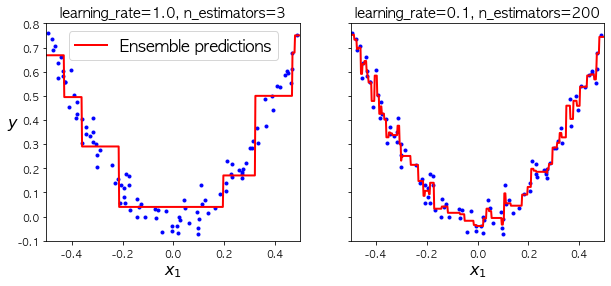

In [493]:
fig, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)

plt.sca(axes[0])
plot_predictions([gbrt], x, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt_slow], x, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)
plt.show()

In [494]:
### Early stopping
x_train, x_val, y_train, y_val = train_test_split(x, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(x_train, y_train)

errors = [mean_squared_error(y_val, y_pred) for y_pred in gbrt.staged_predict(x_val)]
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(x_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=56, random_state=42)

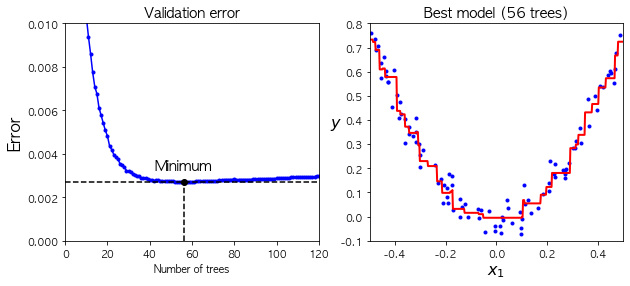

In [495]:
min_error = np.min(errors)

plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.plot(np.arange(1, len(errors) + 1), errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.ylabel("Error", fontsize=16)
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], x, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16)

plt.show()

In [496]:
# 유예가 있는 Early stopping
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(x_train, y_train)
    y_pred = gbrt.predict(x_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_error:
        min_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # early stopping

print(gbrt.n_estimators)
print("Minimum validation MSE:", min_error)

61
Minimum validation MSE: 0.002712853325235463


### (3) XGBoost
- eXtra Gradient Boost

#### Classifier

In [497]:
# !pip install xgboost
import xgboost as xgb
from xgboost import plot_importance
from xgboost import XGBClassifier

In [498]:
dataset = load_breast_cancer()
x_features= dataset.data
y_label = dataset.target

cancer_df = pd.DataFrame(data=x_features, columns=dataset.feature_names)
cancer_df['target']= y_label
cancer_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0


In [499]:
print(dataset.target_names)
print(cancer_df['target'].value_counts())

['malignant' 'benign']
1    357
0    212
Name: target, dtype: int64


In [500]:
# cancer_df에서 feature용 DataFrame과 Label용 Series 객체 추출
# 맨 마지막 칼럼이 Label임. Feature용 DataFrame은 cancer_df의 첫번째 칼럼에서 맨 마지막 두번째 칼럼까지를 :-1 슬라이싱으로 추출.
x_features = cancer_df.iloc[:, :-1]
y_label = cancer_df.iloc[:, -1]

# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
x_train, x_test, y_train, y_test=train_test_split(x_features, y_label, test_size=0.2, random_state=156)

In [501]:
xgb_wrapper = xgb.XGBClassifier(n_estimators=40, learning_rate=0.1, max_depth=3)
xgb_wrapper.fit(x_train, y_train)
w_preds = xgb_wrapper.predict(x_test)
w_pred_proba = xgb_wrapper.predict_proba(x_test)[:, 1]

In [502]:
confusion = confusion_matrix(y_test, w_preds)
accuracy = accuracy_score(y_test, w_preds)
precision = precision_score(y_test, w_preds)
recall = recall_score(y_test, w_preds)
f1 = f1_score(y_test, w_preds)
auc_score = roc_auc_score(y_test, w_pred_proba)
    
print('오차 행렬\n', confusion)
print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1:{3:.4f}, AUC:{3:.4f}'.format(accuracy, precision, recall, f1, auc_score))

오차 행렬
 [[34  3]
 [ 2 75]]
정확도: 0.9561, 정밀도: 0.9615, 재현율: 0.9740, F1:0.9677, AUC:0.9677


In [ ]:
xgb_wrapper = xgb.XGBClassifier(n_estimators=40, learning_rate=0.1, max_depth=3)
evals = [(x_test, y_test)]
xgb_wrapper.fit(x_train, y_train, early_stopping_rounds=10, eval_metric="logloss", eval_set=evals, verbose=True)

ws100_preds = xgb_wrapper.predict(x_test)
ws100_pred_proba = xgb_wrapper.predict_proba(x_test)[:, 1]

In [504]:
confusion = confusion_matrix(y_test, ws100_preds)
accuracy = accuracy_score(y_test, ws100_preds)
precision = precision_score(y_test, ws100_preds)
recall = recall_score(y_test, ws100_preds)
f1 = f1_score(y_test, ws100_preds)
auc_score = roc_auc_score(y_test, ws100_pred_proba)
    
print('오차 행렬\n', confusion)
print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1:{3:.4f}, AUC:{3:.4f}'.format(accuracy, precision, recall, f1, auc_score))

오차 행렬
 [[34  3]
 [ 2 75]]
정확도: 0.9561, 정밀도: 0.9615, 재현율: 0.9740, F1:0.9677, AUC"0.9677


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

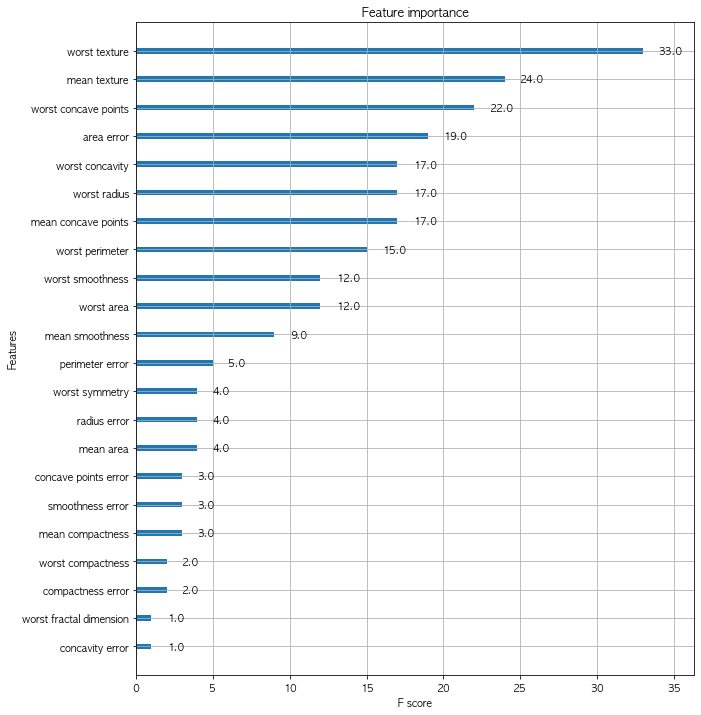

In [505]:
fig, ax = plt.subplots(figsize=(10, 12)) 
plot_importance(xgb_wrapper, ax=ax)

In [506]:
### Bayesian optimization
# max_depth는 5에서 20까지 1간격으로, min_child_weight는 1에서 2까지 1간격으로
# colsample_bytree는 0.5에서 1사이, learning_rate는 0.01에서 0.2 사이 정규 분포된 값으로 검색.
xgb_search_space = {'max_depth': hp.quniform('max_depth', 5, 20, 1), 
                    'min_child_weight': hp.quniform('min_child_weight', 1, 2, 1),
                    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
                    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1)}

In [507]:
# fmin()에서 입력된 search_space 값으로 입력된 모든 값은 실수형임.
# XGBClassifier의 정수형 하이퍼 파라미터는 정수형 변환을 해줘야 함.
# 정확도는 높을수록 더 좋은 수치임. -1 * 정확도를 곱해서 큰 정확도 값일수록 최소가 되도록 변환
def objective_func(search_space):
    # 수행 시간 절약을 위해 nestimators는 100으로 축소
    xgb_clf = XGBClassifier(n_estimators=100, max_depth=int(search_space['max_depth']),
                            min_child_weight=int(search_space['min_child_weight']),
                            learning_rate=search_space['learning_rate'],
                            colsample_bytree=search_space['colsample_bytree'],
                            eval_metric='logloss')
    accuracy = cross_val_score(xgb_clf, x_train, y_train, scoring='accuracy', cv=3)
    
    # accuracy는 cv=3 개수만큼 roc-auc 결과를 리스트로 가짐. 이를 평균해서 반환하되 -1을 곱함.
    return {'loss':-1 * np.mean(accuracy), 'status': STATUS_OK}


In [508]:
trial_val = Trials()
best = fmin(fn=objective_func,
            space=xgb_search_space,
            algo=tpe.suggest,
            max_evals=50, # 최대 반복 횟수를 지정합니다.
            trials=trial_val, rstate=np.random.default_rng(seed=9)) # random number generator
print('best:', best)

100%|█████████████████████████████████████████████████████████████████| 50/50 [00:11<00:00,  4.25trial/s, best loss: -0.9692401533635412]
best: {'colsample_bytree': 0.548301545497125, 'learning_rate': 0.1840281762576621, 'max_depth': 18.0, 'min_child_weight': 2.0}


In [509]:
print('colsample_bytree:{0}, learning_rate:{1}, max_depth:{2}, min_child_weight:{3}'.format(
    round(best['colsample_bytree'], 5), round(best['learning_rate'], 5),
    int(best['max_depth']), int(best['min_child_weight'])))

colsample_bytree:0.5483, learning_rate:0.18403, max_depth:18, min_child_weight:2


In [ ]:
xgb_wrapper = XGBClassifier(n_estimators=400,
                            learning_rate=round(best['learning_rate'], 5),
                            max_depth=int(best['max_depth']),
                            min_child_weight=int(best['min_child_weight']),
                            colsample_bytree=round(best['colsample_bytree'], 5))

evals = [(x_test, y_test)]
xgb_wrapper.fit(x_train, y_train, early_stopping_rounds=50, eval_metric='logloss', eval_set=evals, verbose=True)

pred = xgb_wrapper.predict(x_test)
pred_proba = xgb_wrapper.predict_proba(x_test)[:, 1]

test_cm = confusion_matrix(y_test, pred)
test_acc = accuracy_score(y_test, pred)
test_prc = precision_score(y_test, pred)
test_rcll = recall_score(y_test, pred)
test_f1 = f1_score(y_test, pred)
test_auc = roc_auc_score(y_test, pred_proba)

print(test_cm)
print('정확도\t{}%'.format(round(test_acc * 100, 2)))
print('정밀도\t{}%'.format(round(test_prc * 100, 2)))
print('재현율\t{}%'.format(round(test_rcll * 100, 2)))
print('F1\t{}%'.format(round(test_f1 * 100, 2)))
print('AUC\t{}%'.format(round(test_auc * 100, 2)))

In [511]:
### Santander bank data
cust_df = pd.read_csv("./data/train_santander.csv", encoding='latin-1')
print('dataset shape:', cust_df.shape)
cust_df.head(3)

dataset shape: (76020, 371)


,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.17,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.03,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.77,0


In [512]:
print(cust_df['TARGET'].value_counts())
unsatisfied_cnt = cust_df[cust_df['TARGET'] == 1].TARGET.count()
total_cnt = cust_df.TARGET.count()
print('unsatisfied 비율은 {0:.2f}'.format((unsatisfied_cnt / total_cnt)))

0    73012
1     3008
Name: TARGET, dtype: int64
unsatisfied 비율은 0.04


In [513]:
cust_df.describe()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,75964.050723,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,...,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,43781.947379,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,...,455.887218,113.959637,783.207399,538.439211,2013.125393,147.786584,4040.337842,2852.579397,1.826646e+05,0.194945
min,1.000000,-999999.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.163750e+03,0.000000
25%,38104.750000,2.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.787061e+04,0.000000
50%,76043.000000,2.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.064092e+05,0.000000
75%,113748.750000,2.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.187563e+05,0.000000
max,151838.000000,238.000000,105.000000,210000.000000,12888.030000,21024.810000,8237.820000,11073.570000,6600.000000,6600.000000,...,50003.880000,20385.720000,138831.630000,91778.730000,438329.220000,24650.010000,681462.900000,397884.300000,2.203474e+07,1.000000


In [514]:
cust_df['var3'].value_counts()

 2         74165
 8           138
-999999      116
 9           110
 3           108
           ...  
 231           1
 188           1
 168           1
 135           1
 87            1
Name: var3, Length: 208, dtype: int64

In [515]:
# var3 피처 값 대체 및 ID 피처 드롭
cust_df['var3'].replace(-999999, 2, inplace=True)
cust_df.drop('ID', axis=1, inplace=True)

# 피처 세트와 레이블 세트분리. 레이블 컬럼은 DataFrame의 맨 마지막에 위치해 컬럼 위치 -1로 분리
x_features = cust_df.iloc[:, :-1]
y_labels = cust_df.iloc[:, -1]
print('피처 데이터 shape:{0}'.format(x_features.shape))

피처 데이터 shape:(76020, 369)


In [516]:
x_train, x_test, y_train, y_test = train_test_split(x_features, y_labels, test_size=0.2, random_state=0)

train_cnt = y_train.count()
test_cnt = y_test.count()

print('학습 세트 Shape:{0}, 테스트 세트 Shape:{1}'.format(x_train.shape, x_test.shape))

print(' 학습 세트 레이블 값 분포 비율')
print(y_train.value_counts()/train_cnt)
print('\n 테스트 세트 레이블 값 분포 비율')
print(y_test.value_counts()/test_cnt)

# x_train, y_train을 다시 학습과 검증 데이터 세트로 분리. 
x_tr, x_val, y_tr, y_val = train_test_split(x_train, y_train, test_size=0.3, random_state=0)

학습 세트 Shape:(60816, 369), 테스트 세트 Shape:(15204, 369)
 학습 세트 레이블 값 분포 비율
0    0.960964
1    0.039036
Name: TARGET, dtype: float64

 테스트 세트 레이블 값 분포 비율
0    0.9583
1    0.0417
Name: TARGET, dtype: float64


In [ ]:
# n_estimators는 50으로, learning_rate 0.05, random state는 예제 수행 시마다 동일 예측 결과를 위해 설정. 
xgb_clf = XGBClassifier(n_estimators=50, learning_rate=0.05, random_state=156)

# 성능 평가 지표를 auc로, 조기 중단 파라미터는 20으로 설정하고 학습 수행.
# label 비율이 비대칭이므로
xgb_clf.fit(x_tr, y_tr, early_stopping_rounds=20, eval_metric='auc', eval_set=[(x_tr, y_tr), (x_val, y_val)])

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(x_test)[:, 1])
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

In [518]:
# max_depth는 5에서 15까지 1간격으로, min_child_weight는 1에서 6까지 1간격으로
# colsample_bytree는 0.5에서 0.95사이, learning_rate는 0.01에서 0.2사이 정규 분포된 값으로 검색. 
xgb_search_space = {'max_depth': hp.quniform('max_depth', 5, 15, 1), 
                    'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
                    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 0.95),
                    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2)}

In [519]:
# 목적 함수 설정. 
# 추후 fmin()에서 입력된 search_space값으로 XGBClassifier 교차 검증 학습 후 -1* roc_auc 평균 값을 반환.  
def objective_func(search_space):
    xgb_clf = XGBClassifier(n_estimators=30, max_depth=int(search_space['max_depth']),
                            min_child_weight=int(search_space['min_child_weight']),
                            colsample_bytree=search_space['colsample_bytree'],
                            learning_rate=search_space['learning_rate']
                           )
    # 3개 k-fold 방식으로 평가된 roc_auc 지표를 담는 list
    roc_auc_list= []
    
    # 3개 k-fold방식 적용 
    kf = KFold(n_splits=3)
    # X_train을 다시 학습과 검증용 데이터로 분리
    for tr_index, val_index in kf.split(x_train):
        # kf.split(x_train)으로 추출된 학습과 검증 index값으로 학습과 검증 데이터 세트 분리 
        x_tr, y_tr = x_train.iloc[tr_index], y_train.iloc[tr_index]
        x_val, y_val = x_train.iloc[val_index], y_train.iloc[val_index]
        # early stopping은 20회로 설정하고 추출된 학습과 검증 데이터로 XGBClassifier 학습 수행. 
        xgb_clf.fit(x_tr, y_tr, early_stopping_rounds=20, eval_metric='auc',
                   eval_set=[(x_tr, y_tr), (x_val, y_val)])
    
        # 1로 예측한 확률값 추출후 roc auc 계산하고 평균 roc auc 계산을 위해 list에 결과값 담음. 
        score = roc_auc_score(y_val, xgb_clf.predict_proba(x_val)[:, 1])
        roc_auc_list.append(score)
        
    # 3개 k-fold로 계산된 roc_auc값의 평균값을 반환하되, 
    # HyperOpt는 목적함수의 최소값을 위한 입력값을 찾으므로 -1을 곱한 뒤 반환. 
    return -1 * np.mean(roc_auc_list)

In [ ]:
trials = Trials()

# fmin()함수를 호출. max_evals지정된 횟수만큼 반복 후 목적함수의 최소값을 가지는 최적 입력값 추출.
best = fmin(fn=objective_func,
            space=xgb_search_space,
            algo=tpe.suggest,
            max_evals=5, # 최대 반복 횟수를 지정합니다.
            trials=trials, rstate=np.random.default_rng(seed=30)) # random number generator

print('best:', best)

In [ ]:
# 최적으로 찾은 하이퍼 파라미터를 기반으로 학습과 예측 수행.
xgb_clf = XGBClassifier(n_estimators=100, learning_rate=round(best['learning_rate'], 5),
                        max_depth=int(best['max_depth']), min_child_weight=int(best['min_child_weight']), 
                        colsample_bytree=round(best['colsample_bytree'], 5))

# evaluation metric을 auc로, early stopping은 20 으로 설정하고 학습 수행. 
xgb_clf.fit(x_tr, y_tr, early_stopping_rounds=20, eval_metric="auc",eval_set=[(x_tr, y_tr), (x_val, y_val)])

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(x_test)[:,1])
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

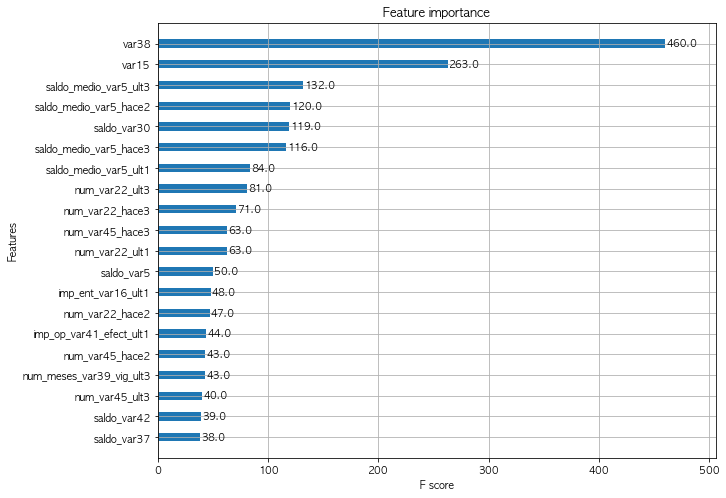

In [522]:
fig, ax = plt.subplots(1, 1, figsize=(10,8))
plot_importance(xgb_clf, ax=ax, max_num_features=20, height=0.4)

#### Regressor

In [523]:
np.random.seed(42)
x = np.random.rand(100, 1) - 0.5
y = 3 * x[:, 0]**2 + 0.05 * np.random.randn(100)

In [524]:
x_train, x_val, y_train, y_val = train_test_split(x, y, random_state=49)

In [525]:
xgb_reg = xgb.XGBRegressor(random_state=42)
xgb_reg.fit(x_train, y_train)
y_pred = xgb_reg.predict(x_val)
val_error = mean_squared_error(y_val, y_pred)
print("Validation MSE:", val_error)

Validation MSE: 0.004000408205406276


In [526]:
xgb_reg.fit(x_train, y_train, eval_set=[(x_val, y_val)], early_stopping_rounds=2) # early stopping
y_pred = xgb_reg.predict(x_val)
val_error = mean_squared_error(y_val, y_pred)
print("Validation MSE:", val_error)

[0]	validation_0-rmse:0.22834
[1]	validation_0-rmse:0.16224
[2]	validation_0-rmse:0.11843
[3]	validation_0-rmse:0.08760
[4]	validation_0-rmse:0.06848
[5]	validation_0-rmse:0.05709
[6]	validation_0-rmse:0.05297
[7]	validation_0-rmse:0.05129
[8]	validation_0-rmse:0.05155
[9]	validation_0-rmse:0.05211
Validation MSE: 0.002630868681577655


### (4) LightGBM
- XGBoost보다 더 빠른 학습 속도
- Leaf Wise tree 분할: 비균형 트리 생성
- Regressor에서 quantile 옵션 적용 가능 (objective = 'quantile', alpha = quantile)

In [527]:
# !pip install lightgbm
from lightgbm import plot_importance
from lightgbm import early_stopping
from lightgbm import LGBMClassifier

In [ ]:
dataset = load_breast_cancer()
cancer_df = pd.DataFrame(data=dataset.data, columns=dataset.feature_names)
cancer_df['target']= dataset.target
x_features = cancer_df.iloc[:, :-1]
y_label = cancer_df.iloc[:, -1]

# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
x_train, x_test, y_train, y_test = train_test_split(x_features, y_label, test_size=0.2, random_state=156)

# 위에서 만든 X_train, y_train을 다시 쪼개서 90%는 학습과 10%는 검증용 데이터로 분리
x_tr, x_val, y_tr, y_val= train_test_split(x_train, y_train, test_size=0.1, random_state=156)

# 앞서 XGBoost와 동일하게 n_estimators는 400 설정.
lgbm_wrapper = LGBMClassifier(n_estimators=40, learning_rate=0.05)

# LightGBM도 XGBoost와 동일하게 조기 중단 수행 가능.
evals = [(x_tr, y_tr), (x_val, y_val)]
                   
lgbm_wrapper.fit(x_tr, y_tr, eval_metric="logloss", eval_set=evals, callbacks=[early_stopping(stopping_rounds=10, first_metric_only=False)])
preds = lgbm_wrapper.predict(x_test)
pred_proba = lgbm_wrapper.predict_proba(x_test)[:, 1]

In [529]:
confusion = confusion_matrix(y_test, preds)
accuracy = accuracy_score(y_test, preds)
precision = precision_score(y_test, preds)
recall = recall_score(y_test, preds)
f1 = f1_score(y_test, preds)
auc_score = roc_auc_score(y_test, pred_proba)
    
print('오차 행렬\n', confusion)
print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1:{3:.4f}, AUC:{3:.4f}'.format(accuracy, precision, recall, f1, auc_score))

오차 행렬
 [[34  3]
 [ 3 74]]
정확도: 0.9474, 정밀도: 0.9610, 재현율: 0.9610, F1:0.9610, AUC:0.9610


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

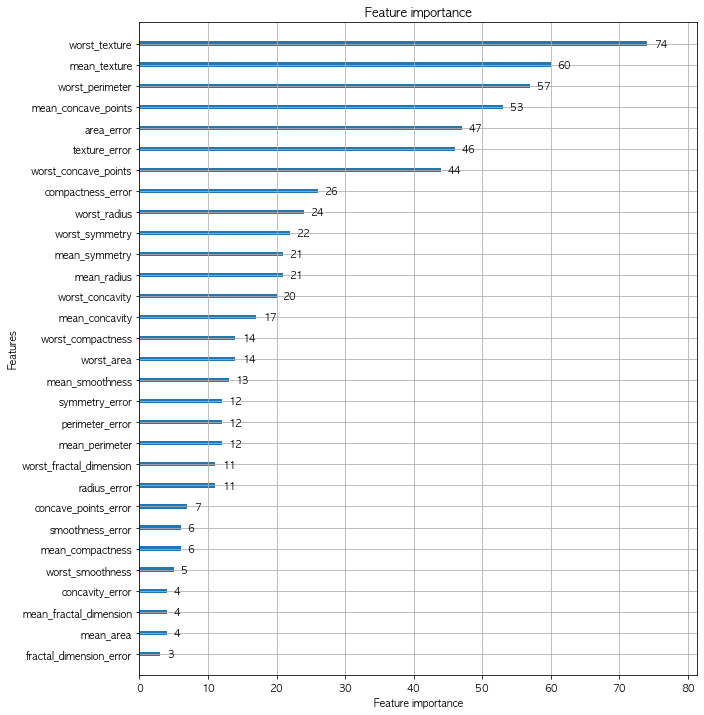

In [530]:
# plot_importance()를 이용하여 feature 중요도 시각화
fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(lgbm_wrapper, ax=ax)

In [531]:
### Santander bank data
cust_df = pd.read_csv("./data/train_santander.csv", encoding='latin-1')
cust_df['var3'].replace(-999999, 2, inplace=True)
cust_df.drop('ID', axis=1, inplace=True)

x_features = cust_df.iloc[:, :-1]
y_labels = cust_df.iloc[:, -1]

x_train, x_test, y_train, y_test = train_test_split(x_features, y_labels, test_size=0.2, random_state=0)
x_tr, x_val, y_tr, y_val = train_test_split(x_train, y_train, test_size=0.3, random_state=0)

In [532]:
lgbm_clf = LGBMClassifier(n_estimators=50)

eval_set=[(x_tr, y_tr), (x_val, y_val)]
lgbm_clf.fit(x_tr, y_tr, eval_metric="auc", eval_set=eval_set, callbacks=[early_stopping(stopping_rounds=20, first_metric_only=False)])

lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(x_test)[:, 1])
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

[LightGBM] [Info] Number of positive: 1658, number of negative: 40913
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035290 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13308
[LightGBM] [Info] Number of data points in the train set: 42571, number of used features: 242
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.038947 -> initscore=-3.205836
[LightGBM] [Info] Start training from score -3.205836
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[41]	training's auc: 0.910173	training's binary_logloss: 0.112442	valid_1's auc: 0.831852	valid_1's binary_logloss: 0.135272
ROC AUC: 0.8386


In [533]:
lgbm_search_space = {'num_leaves': hp.quniform('num_leaves', 32, 64, 1),
                     'max_depth': hp.quniform('max_depth', 100, 160, 1),
                     'min_child_samples': hp.quniform('min_child_samples', 60, 100, 1),
                     'subsample': hp.uniform('subsample', 0.7, 1),
                     'learning_rate': hp.uniform('learning_rate', 0.01, 0.2)}

In [534]:
def objective_func(search_space):
    lgbm_clf =  LGBMClassifier(n_estimators=50, num_leaves=int(search_space['num_leaves']),
                               max_depth=int(search_space['max_depth']),
                               min_child_samples=int(search_space['min_child_samples']), 
                               subsample=search_space['subsample'],
                               learning_rate=search_space['learning_rate'])
    # 3개 k-fold 방식으로 평가된 roc_auc 지표를 담는 list
    roc_auc_list = []
    
    # 3개 k-fold방식 적용 
    kf = KFold(n_splits=3)
    # x_train을 다시 학습과 검증용 데이터로 분리
    for tr_index, val_index in kf.split(x_train):
        # kf.split(X_train)으로 추출된 학습과 검증 index값으로 학습과 검증 데이터 세트 분리 
        x_tr, y_tr = x_train.iloc[tr_index], y_train.iloc[tr_index]
        x_val, y_val = x_train.iloc[val_index], y_train.iloc[val_index]

        # early stopping은 20회로 설정하고 추출된 학습과 검증 데이터로 XGBClassifier 학습 수행.
        lgbm_clf.fit(x_tr, y_tr, eval_metric="auc", eval_set=eval_set, callbacks=[early_stopping(stopping_rounds=20, first_metric_only=False)])

        # 1로 예측한 확률값 추출후 roc auc 계산하고 평균 roc auc 계산을 위해 list에 결과값 담음.
        score = roc_auc_score(y_val, lgbm_clf.predict_proba(x_val)[:, 1]) 
        roc_auc_list.append(score)
    
    # 3개 k-fold로 계산된 roc_auc값의 평균값을 반환하되, 
    # HyperOpt는 목적함수의 최소값을 위한 입력값을 찾으므로 -1을 곱한 뒤 반환.
    return -1 * np.mean(roc_auc_list)

In [ ]:
trials = Trials()

# fmin()함수를 호출. max_evals지정된 횟수만큼 반복 후 목적함수의 최소값을 가지는 최적 입력값 추출. 
best = fmin(fn=objective_func, space=lgbm_search_space, algo=tpe.suggest,
            max_evals=5, # 최대 반복 횟수를 지정합니다.
            trials=trials, rstate=np.random.default_rng(seed=30))

print('best:', best)

In [536]:
lgbm_clf =  LGBMClassifier(n_estimators=100, num_leaves=int(best['num_leaves']),
                           max_depth=int(best['max_depth']),
                           min_child_samples=int(best['min_child_samples']), 
                           subsample=round(best['subsample'], 5),
                           learning_rate=round(best['learning_rate'], 5))

# evaluation metric을 auc로, early stopping은 20 으로 설정하고 학습 수행. 
lgbm_clf.fit(x_tr, y_tr, eval_metric="auc", eval_set=eval_set, callbacks=[early_stopping(stopping_rounds=20, first_metric_only=False)])

lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(x_test)[:,1])
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

[LightGBM] [Info] Number of positive: 1658, number of negative: 40913
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020935 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12898
[LightGBM] [Info] Number of data points in the train set: 42571, number of used features: 192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.038947 -> initscore=-3.205836
[LightGBM] [Info] Start training from score -3.205836
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[57]	training's auc: 0.912105	training's binary_logloss: 0.112927	valid_1's auc: 0.830226	valid_1's binary_logloss: 0.135608
ROC AUC: 0.8394


## RandomForest
- Bagging에 랜덤 과정을 추가한 트리 기반 모델
- 예측변수들을 임의로 추출하여 Bootstrap 샘플 구성
- input 변수가 많을수록 좋은 성능

### (1) Classifier

In [537]:
features = ["area_mean", "texture_mean"]

x = breast[features]
y = breast["diagnosis"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, stratify=y, random_state=1)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(398, 2) (171, 2) (398,) (171,)


In [538]:
from sklearn.ensemble import RandomForestClassifier

In [539]:
clf = RandomForestClassifier(n_estimators=100, min_samples_split=5)

In [540]:
pred = clf.fit(x_train, y_train).predict(x_test)
print("정확도: ", clf.score(x_test, y_test))

정확도:  0.8947368421052632


In [541]:
test_cm=confusion_matrix(y_test, pred)
test_acc=accuracy_score(y_test, pred)
test_prc=precision_score(y_test, pred)
test_rcll=recall_score(y_test, pred)
test_f1=f1_score(y_test, pred)

print(test_cm)
print('정확도\t{}%'.format(round(test_acc *100,2)))
print('정밀도\t{}%'.format(round(test_prc *100,2)))
print('재현율\t{}%'.format(round(test_rcll *100,2)))
print('F1\t{}%'.format(round(test_f1 * 100, 2)))

[[102   5]
 [ 13  51]]
정확도	89.47%
정밀도	91.07%
재현율	79.69%
F1	85.0%


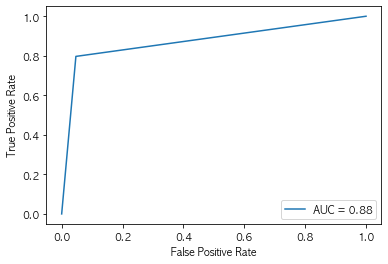

In [543]:
fpr, tpr, thresholds = roc_curve(y_test, pred)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc) # plot_roc_curve(clf, x_test, y_test)
display.plot()
plt.show()

In [544]:
importances = clf.feature_importances_
column_nm = pd.DataFrame(["area_mean", "texture_mean"])
feature_importances = pd.concat([column_nm, pd.DataFrame(importances)], axis=1)
feature_importances.columns = ['feature_nm', 'importances']
print(feature_importances)

     feature_nm  importances
0     area_mean     0.709804
1  texture_mean     0.290196


<AxesSubplot:>

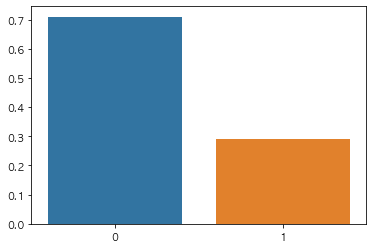

In [545]:
xtick_label_position = list(range(len(features)))
plt.xticks(xtick_label_position, features)
sns.barplot([x for x in range(len(importances))], importances)

In [546]:
### stageC data
stagec.head()

### Data split
x_train, x_test, y_train, y_test = train_test_split(stagec.drop('ploidy', axis=1), stagec['ploidy'], test_size=0.2, random_state=0, stratify=stagec['ploidy'])

In [547]:
rand_clf = RandomForestClassifier(n_estimators=100, min_samples_split=5)
rand_clf.fit(x_train, y_train)

RandomForestClassifier(min_samples_split=5)

In [548]:
pred = rand_clf.predict(x_test)
test_cm = confusion_matrix(y_test, pred)
test_acc = accuracy_score(y_test, pred)

print(test_cm)
print('정확도\t{}%'.format(round(test_acc *100,2)))

[[ 0  1  0]
 [ 0 13  0]
 [ 0  0 13]]
정확도	96.3%


In [549]:
importances = rand_clf.feature_importances_
feature_names = stagec.columns.difference(['ploidy'])
std = np.std([tree.feature_importances_ for tree in rand_clf.estimators_], axis=0)

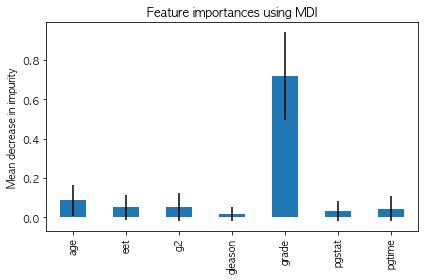

In [550]:
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [551]:
### feature importance of iris data
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(iris.iloc[:, :4], iris["Class"])
for name, score in zip(iris.columns.difference(['Class']), rnd_clf.feature_importances_):
    print(name, score)

petal length (cm) 0.08952515598716533
petal width (cm) 0.030922148878262813
sepal length (cm) 0.4426339361506208
sepal width (cm) 0.43691875898395105


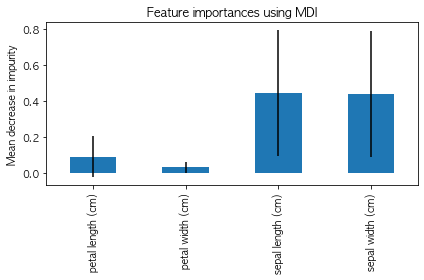

In [552]:
forest_importances = pd.Series(rnd_clf.feature_importances_, index=iris.columns.difference(['Class']))
std = np.std([tree.feature_importances_ for tree in rnd_clf.estimators_], axis=0)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [553]:
### Moons data
x, y = make_moons(n_samples=500, noise=0.30, random_state=42)
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)

In [554]:
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, random_state=42)
rnd_clf.fit(x_train, y_train)

y_pred_rf = rnd_clf.predict(x_test)

In [555]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(max_features="sqrt", max_leaf_nodes=16), n_estimators=500, random_state=42)

In [556]:
bag_clf.fit(x_train, y_train)
y_pred = bag_clf.predict(x_test)

### Tree Bagging과 유사한 결과
np.sum(y_pred == y_pred_rf) / len(y_pred)

1.0

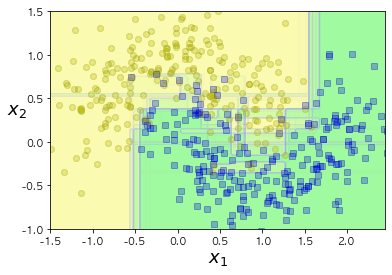

In [557]:
plt.figure(figsize=(6, 4))

for i in range(15):
    tree_clf = DecisionTreeClassifier(max_leaf_nodes=16, random_state=42 + i)
    indices_with_replacement = np.random.randint(0, len(x_train), len(x_train))
    tree_clf.fit(x_train[indices_with_replacement], y_train[indices_with_replacement])
    
    x1s = np.linspace(-1.5, 2.45, 100)
    x2s = np.linspace(-1, 1.5, 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    x_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = tree_clf.predict(x_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)

    plt.plot(x[:, 0][y==0], x[:, 1][y==0], "yo", alpha=0.02)
    plt.plot(x[:, 0][y==1], x[:, 1][y==1], "bs", alpha=0.02)
    plt.axis([-1.5, 2.45, -1, 1.5])
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

plt.show()

In [558]:
# DTree에서 사용한 get_human_dataset()을 이용해 학습/테스트용 DataFrame 반환
x_train, x_test, y_train, y_test = get_human_dataset()

# 랜덤 포레스트 학습 및 별도의 테스트 셋으로 예측 성능 평가
rf_clf = RandomForestClassifier(random_state=0)
rf_clf.fit(x_train, y_train)

pred = rf_clf.predict(x_test)
accuracy = accuracy_score(y_test, pred)
print('랜덤 포레스트 정확도: {0:.4f}'.format(accuracy))

랜덤 포레스트 정확도: 0.9253


In [559]:
params = {'n_estimators': [100],
          'max_depth': [6, 8, 10, 12], 
          'min_samples_leaf': [8, 12, 18],
          'min_samples_split': [8, 16, 20]}

# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
rf_clf = RandomForestClassifier(random_state=0, n_jobs=-1)
grid_cv = GridSearchCV(rf_clf, param_grid=params, cv=2, n_jobs=-1)
grid_cv.fit(x_train, y_train)

print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

최적 하이퍼 파라미터:
 {'max_depth': 10, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 100}
최고 예측 정확도: 0.9180


In [560]:
rf_clf1 = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_leaf=8, min_samples_split=8, random_state=0)
rf_clf1.fit(x_train, y_train)
pred = rf_clf1.predict(x_test)
print('예측 정확도: {0:.4f}'.format(accuracy_score(y_test, pred)))

예측 정확도: 0.9196


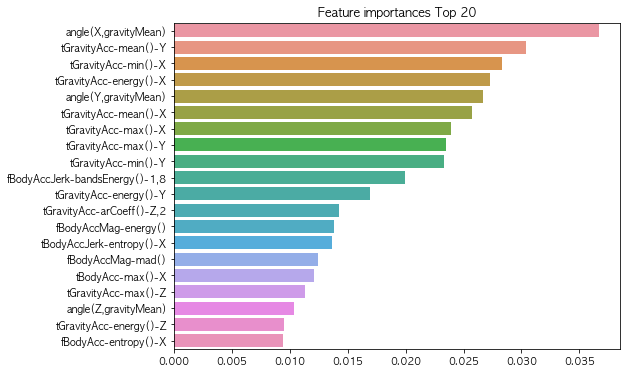

In [561]:
ftr_importances_values = rf_clf1.feature_importances_
ftr_importances = pd.Series(ftr_importances_values,index=x_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Feature importances Top 20')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()

### (2) Regressor

In [562]:
car_num = car.select_dtypes(['number'])
features = list(car_num.columns.difference(['car_ID', 'symboling', 'price']))
x = car_num[features]
y = car_num['price']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(143, 13) (62, 13) (143,) (62,)


In [563]:
from sklearn.ensemble import RandomForestRegressor

In [564]:
reg = RandomForestRegressor()
pred = reg.fit(x_train, y_train).predict(x_test)

mse = mean_squared_error(y_test, pred)
mae = mean_absolute_error(y_test, pred)
rmse = np.sqrt(mse)
acc = reg.score(x_test, y_test)

print('MSE\t{}'.format(round(mse,3)))
print('MAE\t{}'.format(round(mae,3)))
print('RMSE\t{}'.format(round(rmse,3)))
print('ACC\t{}%'.format(round(acc *100,3)))

MSE	4426379.228
MAE	1379.732
RMSE	2103.896
ACC	92.668%


In [565]:
importances = reg.feature_importances_
column_nm = pd.DataFrame(features)
feature_importances = pd.concat([column_nm, pd.DataFrame(importances)], axis=1)
feature_importances.columns = ['feature_nm', 'importances']
print(feature_importances)

          feature_nm  importances
0          boreratio     0.005721
1          carheight     0.003067
2          carlength     0.006897
3           carwidth     0.023005
4            citympg     0.009486
5   compressionratio     0.004002
6         curbweight     0.162258
7         enginesize     0.674463
8         highwaympg     0.062149
9         horsepower     0.022721
10           peakrpm     0.006934
11            stroke     0.003200
12         wheelbase     0.016095


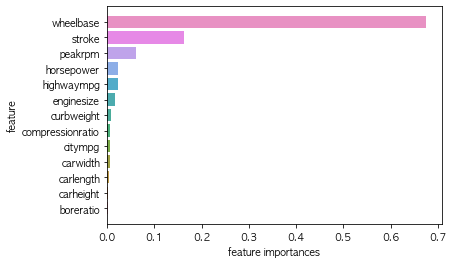

In [566]:
n_features = x_train.shape[1]
importances = pd.Series(reg.feature_importances_, index=x_train.columns).sort_values()
column_nm = features

sns.barplot(x=importances, y=column_nm)
plt.yticks(np.arange(n_features), column_nm)
plt.xlabel("feature importances")
plt.ylabel("feature")
plt.ylim(-1, n_features)
plt.show()

## Voting
- 여러 모델의 결과를 가지고 투표를 통해 최종 output 생서
- Voting의 결과물이 반드시 좋은 것은 아님

### (1) Classifier
- Hard voting: 다수결 원칙. 모델의 가중치를 조정하기 용이
- Soft voting: 각 Class의 확률을 평균하여 결정
    - 확률이 높은 투표에 조금 더 비중이 있음
    - 성능이 대체적으로 더 좋은 편

In [567]:
x, y = make_moons(n_samples=500, noise=0.30, random_state=42)
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)

In [568]:
from sklearn.ensemble import VotingClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [569]:
log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", random_state=42, probability=True)

In [570]:
### hard voting
voting_clf = VotingClassifier(estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)], voting='hard')
voting_clf.fit(x_train, y_train)

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


In [571]:
### soft voting
voting_clf = VotingClassifier(estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)], voting='soft')
voting_clf.fit(x_train, y_train)

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


In [572]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

In [573]:
### Breast cancer data
cancer = load_breast_cancer()

data_df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
data_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758


In [574]:
# 개별 모델은 로지스틱 회귀와 KNN
lr_clf = LogisticRegression(solver='liblinear')
knn_clf = KNeighborsClassifier(n_neighbors=8)

# 개별 모델을 소프트 보팅 기반의 앙상블 모델로 구현한 분류기 
vo_clf = VotingClassifier(estimators=[('LR', lr_clf), ('KNN', knn_clf)] , voting='soft')

x_train, x_test, y_train, y_test = train_test_split(cancer.data, cancer.target, test_size=0.2, random_state=156)

# VotingClassifier 학습/예측/평가. 
vo_clf.fit(x_train , y_train)
pred = vo_clf.predict(x_test)
print('Voting 분류기 정확도: {0:.4f}'.format(accuracy_score(y_test , pred)))

# 개별 모델의 학습/예측/평가.
classifiers = [lr_clf, knn_clf]
for classifier in classifiers:
    classifier.fit(x_train , y_train)
    pred = classifier.predict(x_test)
    class_name= classifier.__class__.__name__
    print('{0} 정확도: {1:.4f}'.format(class_name, accuracy_score(y_test, pred)))

Voting 분류기 정확도: 0.9561
LogisticRegression 정확도: 0.9474
KNeighborsClassifier 정확도: 0.9386


### (2) Regressor

In [575]:
bike_df = pd.read_csv('./data/bike_train.csv')
print(bike_df.shape)
bike_df.head(3)

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32


In [576]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [577]:
# 문자열을 datetime 타입으로 변경. 
bike_df['datetime'] = bike_df.datetime.apply(pd.to_datetime)

# datetime 타입에서 년, 월, 일, 시간 추출
bike_df['year'] = bike_df.datetime.apply(lambda x: x.year)
bike_df['month'] = bike_df.datetime.apply(lambda x: x.month)
bike_df['day'] = bike_df.datetime.apply(lambda x: x.day)
bike_df['hour'] = bike_df.datetime.apply(lambda x: x.hour)
bike_df.head(3)

drop_columns = ['datetime', 'casual', 'registered']
bike_df.drop(drop_columns, axis=1, inplace=True)

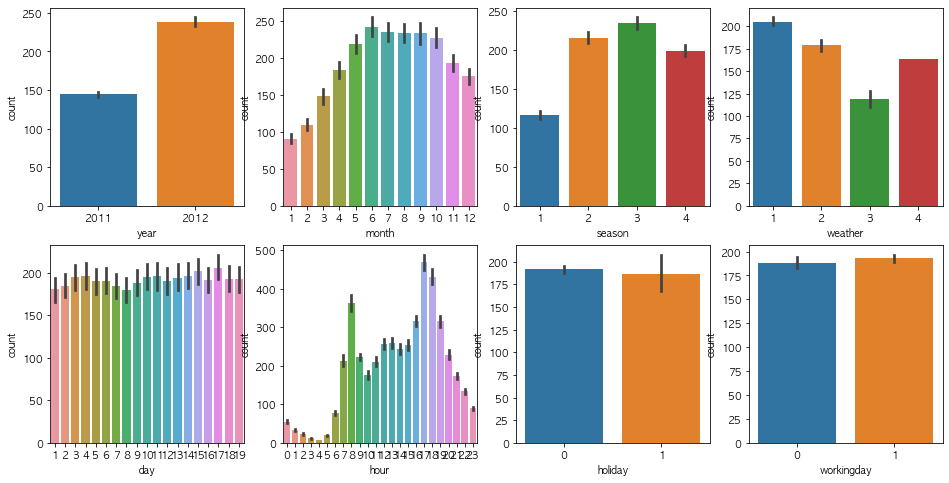

In [578]:
fig, axs = plt.subplots(figsize=(16, 8), ncols=4, nrows=2)
cat_features = ['year', 'month', 'season', 'weather', 'day', 'hour', 'holiday', 'workingday']
# cat_features에 있는 모든 칼럼별로 개별 칼럼값에 따른 count의 합을 barplot으로 시각화
for i, feature in enumerate(cat_features):
    row = int(i/4)
    col = i%4
    # 시본의 barplot을 이용해 칼럼값에 따른 count의 합을 표현
    sns.barplot(x=feature, y='count', data=bike_df, ax=axs[row][col])

In [579]:
x = bike_df.drop(['count'], axis=1, inplace=False)
y = bike_df['count']

<AxesSubplot:>

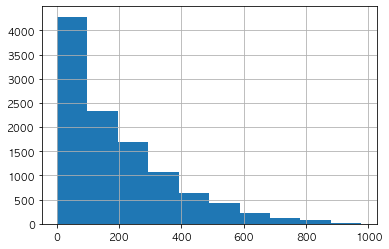

In [580]:
y.hist()

<AxesSubplot:>

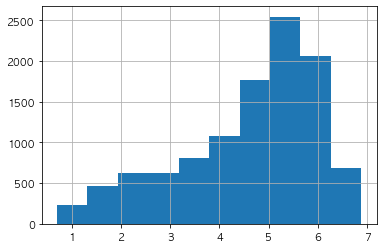

In [581]:
# Log transformation of y
y_log_transform = np.log1p(y)
y_log_transform.hist()

In [582]:
# 'year', month', 'day', hour'등의 피처들을 One Hot Encoding
x_ohe = pd.get_dummies(x, columns=['year', 'month', 'day', 'hour', 'holiday', 'workingday', 'season', 'weather'])

In [583]:
# 타깃 칼럼인 count 값을 log1p로 로그 변환
y_log = np.log1p(y)

# 원-핫 인코딩이 적용된 feature 데이터 세트와 로그 변환된 y_target_log를 반영하여 학습/테스트 데이터 셋 분할
x_train, x_test, y_train, y_test = train_test_split(x_ohe, y_log, test_size=0.3, random_state=0)

In [584]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [585]:
# log 값 변환 시 NaN등의 이슈로 log() 가 아닌 log1p() 를 이용하여 RMSLE 계산
def rmsle(y, pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred) ** 2
    rmsle = np.sqrt(np.mean(squared_error))
    
    return rmsle

In [586]:
# 개별 모델 성능 평가
lr_reg = LinearRegression()
ridge_reg = Ridge(alpha=10)
lasso_reg = Lasso(alpha=0.01)

rf_reg = RandomForestRegressor(n_estimators=50)
gbm_reg = GradientBoostingRegressor(n_estimators=50)
xgb_reg = XGBRegressor(n_estimators=50)
lgbm_reg = LGBMRegressor(n_estimators=50)

y_test = np.expm1(y_test)

# XGBoost의 경우 DataFrame이 입력 될 경우 버전에 따라 오류 발생 가능. ndarray로 변환.
for model in [lr_reg, ridge_reg, lasso_reg, rf_reg, gbm_reg, xgb_reg, lgbm_reg]:
    model.fit(x_train.values, y_train.values)
    pred = model.predict(x_test.values)

    pred = np.expm1(pred)
    print('###',model.__class__.__name__,'###')
    
    rmsle_val = rmsle(y_test, pred)
    rmse_val = mean_squared_error(y_test, pred, squared=True)
    mae_val = mean_absolute_error(y_test, pred)
    print('RMSLE: {0:.3f}, RMSE: {1:.3F}, MAE: {2:.3F}'.format(rmsle_val, rmse_val, mae_val))

### LinearRegression ###
RMSLE: 0.590, RMSE: 9542.892, MAE: 63.382
### Ridge ###
RMSLE: 0.590, RMSE: 9707.883, MAE: 63.893
### Lasso ###
RMSLE: 0.635, RMSE: 12818.499, MAE: 72.803
### RandomForestRegressor ###
RMSLE: 0.358, RMSE: 2578.563, MAE: 31.334
### GradientBoostingRegressor ###
RMSLE: 0.621, RMSE: 16048.815, MAE: 78.591
### XGBRegressor ###
RMSLE: 0.354, RMSE: 3316.650, MAE: 35.152
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001947 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 348
[LightGBM] [Info] Number of data points in the train set: 7620, number of used features: 72
[LightGBM] [Info] Start training from score 4.582043
### LGBMRegressor ###
RMSLE: 0.371, RMSE: 4182.161, MAE: 40.203


In [587]:
# 개별 모델 Voting
vo_reg = VotingRegressor(estimators=[('LR', lr_reg), ('Ridge', ridge_reg), ('Lasso', lasso_reg), ('RF', rf_reg), ('GBM', gbm_reg), ('XGB', xgb_reg), ('LGBM', lgbm_reg)])

vo_reg.fit(x_train, y_train)
pred = vo_reg.predict(x_test)
pred = np.expm1(pred)

rmsle_val = rmsle(y_test, pred)
rmse_val = mean_squared_error(y_test, pred, squared=False)
mae_val = mean_absolute_error(y_test, pred)
print('RMSLE: {0:.3f}, RMSE: {1:.3F}, MAE: {2:.3F}'.format(rmsle_val, rmse_val, mae_val))

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000214 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 348
[LightGBM] [Info] Number of data points in the train set: 7620, number of used features: 72
[LightGBM] [Info] Start training from score 4.582043
RMSLE: 0.448, RMSE: 80.744, MAE: 50.780


<AxesSubplot:>

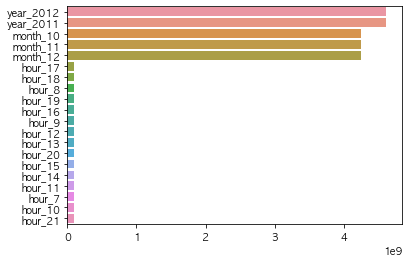

In [588]:
# Linear Regression coef 파악
coef = pd.Series(lr_reg.coef_, index=x_ohe.columns)
coef_sort = coef.sort_values(ascending=False)[:20]
sns.barplot(x=coef_sort.values, y=coef_sort.index)

In [589]:
# DataFrame에 컬럼들로 실제 대여횟수(count)와 예측 값을 서로 비교 할 수 있도록 생성. 
result_df = pd.DataFrame(y_test.values, columns=['real_count'])
result_df['predicted_count']= np.round(pred)
result_df['diff'] = np.abs(result_df['real_count'] - result_df['predicted_count'])
# 예측값과 실제값이 가장 큰 데이터 순으로 출력. 
print(result_df.sort_values('diff', ascending=False)[:5])

      real_count  predicted_count   diff
2817       856.0            410.0  446.0
1181       891.0            453.0  438.0
3115       651.0            266.0  385.0
370        686.0            305.0  381.0
565        512.0            141.0  371.0


In [590]:
### mercari price data
mercari_df= pd.read_csv('./data/mercari_train.tsv', sep='\t')
print(mercari_df.shape)
mercari_df.head(3)

(1482535, 8)


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...


In [591]:
print(mercari_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   train_id           1482535 non-null  int64  
 1   name               1482535 non-null  object 
 2   item_condition_id  1482535 non-null  int64  
 3   category_name      1476208 non-null  object 
 4   brand_name         849853 non-null   object 
 5   price              1482535 non-null  float64
 6   shipping           1482535 non-null  int64  
 7   item_description   1482531 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB
None


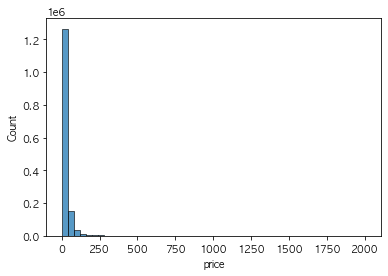

In [592]:
y_train_df = mercari_df['price']

plt.figure(figsize=(6, 4))
sns.histplot(y_train_df, bins=50)
plt.show()

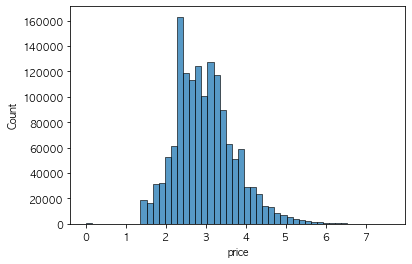

In [593]:
y_train_df = np.log1p(y_train_df)
sns.histplot(y_train_df, bins=50)
plt.show()

In [594]:
mercari_df['price'] = np.log1p(mercari_df['price'])
mercari_df['price'].head(3)

0    2.397895
1    3.970292
2    2.397895
Name: price, dtype: float64

In [595]:
print('Shipping 값 유형:\n', mercari_df['shipping'].value_counts())
print('item_condition_id 값 유형:\n', mercari_df['item_condition_id'].value_counts())

Shipping 값 유형:
 0    819435
1    663100
Name: shipping, dtype: int64
item_condition_id 값 유형:
 1    640549
3    432161
2    375479
4     31962
5      2384
Name: item_condition_id, dtype: int64


In [596]:
boolean_cond = mercari_df['item_description']=='No description yet'
mercari_df[boolean_cond]['item_description'].count()

82489

In [597]:
# apply lambda에서 호출되는 대,중,소 분할 함수 생성, 대,중,소 값을 리스트 반환
def split_cat(category_name):
    try:
        return category_name.split('/')
    except:
        return ['Other_Null' , 'Other_Null' , 'Other_Null']

# 위의 split_cat( )을 apply lambda에서 호출하여 대,중,소 컬럼을 mercari_df에 생성. 
mercari_df['cat_dae'], mercari_df['cat_jung'], mercari_df['cat_so'] = zip(*mercari_df['category_name'].apply(lambda x: split_cat(x)))

# 대분류만 값의 유형과 건수를 살펴보고, 중분류, 소분류는 값의 유형이 많으므로 분류 갯수만 추출
print('대분류 유형 :\n', mercari_df['cat_dae'].value_counts())
print('중분류 갯수 :', mercari_df['cat_jung'].nunique())
print('소분류 갯수 :', mercari_df['cat_so'].nunique())

대분류 유형 :
 Women                     664385
Beauty                    207828
Kids                      171689
Electronics               122690
Men                        93680
Home                       67871
Vintage & Collectibles     46530
Other                      45351
Handmade                   30842
Sports & Outdoors          25342
Other_Null                  6327
Name: cat_dae, dtype: int64
중분류 갯수 : 114
소분류 갯수 : 871


In [598]:
mercari_df['brand_name'] = mercari_df['brand_name'].fillna(value='Other_Null')
mercari_df['category_name'] = mercari_df['category_name'].fillna(value='Other_Null')
mercari_df['item_description'] = mercari_df['item_description'].fillna(value='Other_Null')

# 각 컬럼별로 Null값 건수 확인. 모두 0가 나와야 합니다.
mercari_df.isnull().sum()

train_id             0
name                 0
item_condition_id    0
category_name        0
brand_name           0
price                0
shipping             0
item_description     0
cat_dae              0
cat_jung             0
cat_so               0
dtype: int64

In [599]:
print('brand name 의 유형 건수 :', mercari_df['brand_name'].nunique())
print('brand name sample 5건 : \n', mercari_df['brand_name'].value_counts()[:5])

print('name 의 종류 갯수 :', mercari_df['name'].nunique())
print('name sample 7건 : \n', mercari_df['name'][:7])

brand name 의 유형 건수 : 4810
brand name sample 5건 : 
 Other_Null           632682
PINK                  54088
Nike                  54043
Victoria's Secret     48036
LuLaRoe               31024
Name: brand_name, dtype: int64
name 의 종류 갯수 : 1225273
name sample 7건 : 
 0    MLB Cincinnati Reds T Shirt Size XL
1       Razer BlackWidow Chroma Keyboard
2                         AVA-VIV Blouse
3                  Leather Horse Statues
4                   24K GOLD plated rose
5       Bundled items requested for Ruie
6     Acacia pacific tides santorini top
Name: name, dtype: object


In [600]:
pd.set_option('max_colwidth', 200)

# item_description의 평균 문자열 개수
print('item_description 평균 문자열 개수:', mercari_df['item_description'].str.len().mean())

mercari_df['item_description'][:2]

item_description 평균 문자열 개수: 145.7113889385411


0                                                                                                                                                                              No description yet
1    This keyboard is in great condition and works like it came out of the box. All of the ports are tested and work perfectly. The lights are customizable via the Razer Synapse app on your PC.
Name: item_description, dtype: object

In [601]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer

In [602]:
# name 속성에 대한 feature vectorization 변환
cnt_vec = CountVectorizer()
x_name = cnt_vec.fit_transform(mercari_df.name)

# item_description 에 대한 feature vectorization 변환 
tfidf_descp = TfidfVectorizer(max_features=5000, ngram_range=(1, 3), stop_words='english')
x_descp = tfidf_descp.fit_transform(mercari_df['item_description'])

print('name vectorization shape:', x_name.shape)
print('item_description vectorization shape:', x_descp.shape)

name vectorization shape: (1482535, 105757)
item_description vectorization shape: (1482535, 5000)


In [ ]:
# brand_name, item_condition_id, shipping 각 피처들을 희소 행렬 원-핫 인코딩 변환
lb_brand_name = LabelBinarizer(sparse_output=True) # 희소 행렬 One-hot encoding에 사용
x_brand = lb_brand_name.fit_transform(mercari_df['brand_name'])

lb_item_cond_id = LabelBinarizer(sparse_output=True)
x_item_cond_id = lb_item_cond_id.fit_transform(mercari_df['item_condition_id'])

lb_shipping= LabelBinarizer(sparse_output=True)
x_shipping = lb_shipping.fit_transform(mercari_df['shipping'])

# cat_dae, cat_jung, cat_so 각 피처들을 희소 행렬 원-핫 인코딩 변환
lb_cat_dae = LabelBinarizer(sparse_output=True)
x_cat_dae= lb_cat_dae.fit_transform(mercari_df['cat_dae'])

lb_cat_jung = LabelBinarizer(sparse_output=True)
x_cat_jung = lb_cat_jung.fit_transform(mercari_df['cat_jung'])

lb_cat_so = LabelBinarizer(sparse_output=True)
x_cat_so = lb_cat_so.fit_transform(mercari_df['cat_so'])

In [604]:
print(type(x_brand), type(x_item_cond_id), type(x_shipping))
print('x_brand_shape:{0}, x_item_cond_id shape:{1}'.format(x_brand.shape, x_item_cond_id.shape))
print('x_shipping shape:{0}, x_cat_dae shape:{1}'.format(x_shipping.shape, x_cat_dae.shape))
print('x_cat_jung shape:{0}, x_cat_so shape:{1}'.format(x_cat_jung.shape, x_cat_so.shape))

<class 'scipy.sparse._csr.csr_matrix'> <class 'scipy.sparse._csr.csr_matrix'> <class 'scipy.sparse._csr.csr_matrix'>
x_brand_shape:(1482535, 4810), x_item_cond_id shape:(1482535, 5)
x_shipping shape:(1482535, 1), x_cat_dae shape:(1482535, 11)
x_cat_jung shape:(1482535, 114), x_cat_so shape:(1482535, 871)


In [605]:
import gc
from scipy.sparse import hstack

In [606]:
sparse_matrix_list = (x_name, x_descp, x_brand, x_item_cond_id, x_shipping, x_cat_dae, x_cat_jung, x_cat_so)

# 사이파이 sparse 모듈의 hstack 함수를 이용하여 앞에서 인코딩과 Vectorization을 수행한 데이터 셋을 모두 결합. 
x_features_sparse = hstack(sparse_matrix_list).tocsr()
print(type(x_features_sparse), x_features_sparse.shape)

# 데이터 셋이 메모리를 많이 차지하므로 사용 용도가 끝났으면 바로 메모리에서 삭제. 
del x_features_sparse
gc.collect()

<class 'scipy.sparse._csr.csr_matrix'> (1482535, 116569)


0

In [607]:
from sklearn.linear_model import Ridge
from lightgbm import LGBMRegressor

In [608]:
def rmsle(y, y_pred):
    # underflow, overflow를 막기 위해 log가 아닌 log1p로 rmsle 계산 
    return np.sqrt(np.mean(np.power(np.log1p(y) - np.log1p(y_pred), 2)))

def model_train_predict(model, matrix_list):
    # scipy.sparse 모듈의 hstack 을 이용하여 sparse matrix 결합
    x = hstack(matrix_list).tocsr()     
    
    x_train, x_test, y_train, y_test=train_test_split(x, mercari_df['price'], test_size=0.2, random_state=156)
    
    # 모델 학습 및 예측
    model.fit(x_train, y_train)
    preds = model.predict(x_test)
    
    del x, x_train, x_test, y_train 
    gc.collect()
    
    return preds, y_test

In [609]:
linear_model = Ridge(solver = "lsqr", fit_intercept=False)

sparse_matrix_list = (x_name, x_brand, x_item_cond_id, x_shipping, x_cat_dae, x_cat_jung, x_cat_so)
linear_preds, y_test = model_train_predict(model=linear_model, matrix_list=sparse_matrix_list)

    
# rmsle로 RMSLE 값 추출
print('Item Description을 제외했을 때 rmsle 값:', rmsle(np.expm1(y_test), np.expm1(linear_preds)))

sparse_matrix_list = (x_descp, x_name, x_brand, x_item_cond_id, x_shipping, x_cat_dae, x_cat_jung, x_cat_so)
linear_preds, y_test = model_train_predict(model=linear_model, matrix_list=sparse_matrix_list)

print('Item Description을 포함한 rmsle 값:', rmsle(np.expm1(y_test), np.expm1(linear_preds)))

Item Description을 제외했을 때 rmsle 값: 0.5013204694672296
Item Description을 포함한 rmsle 값: 0.4796521316182503


In [610]:
lgbm_model = LGBMRegressor(n_estimators=50, learning_rate=0.5, num_leaves=125, random_state=156)
lgbm_preds, y_test = model_train_predict(model=lgbm_model, matrix_list=sparse_matrix_list)

print('LightGBM rmsle 값:', rmsle(np.expm1(y_test), np.expm1(lgbm_preds)))

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 28.934477 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 590432
[LightGBM] [Info] Number of data points in the train set: 1186028, number of used features: 20347
[LightGBM] [Info] Start training from score 2.979514
LightGBM rmsle 값: 0.4795177745165347


In [611]:
# 개별 모델 Voting
vo_reg = VotingRegressor(estimators=[('Ridge', linear_model), ('LGBM', lgbm_model)])
vo_preds, y_test = model_train_predict(model=vo_reg, matrix_list=sparse_matrix_list)
print('LightGBM과 Ridge를 ensemble한 최종 rmsle 값:',  rmsle(np.expm1(y_test), np.expm1(vo_preds)))

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 27.720350 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 590432
[LightGBM] [Info] Number of data points in the train set: 1186028, number of used features: 20347
[LightGBM] [Info] Start training from score 2.979514
LightGBM과 Ridge를 ensemble한 최종 rmsle 값: 0.46589156500065404


## Stacking
- Stacked generalization
- 여러 모델의 예측을 취합하는 새로운 모델(Blender, Meta learner) 훈련
- 수행 시간 대비 성능이 좋은 편은 아님

### (1) Classifier

In [612]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

In [613]:
cancer_data = load_breast_cancer()
x_data = cancer_data.data
y_label = cancer_data.target

x_train, x_test, y_train, y_test = train_test_split(x_data, y_label, test_size=0.2, random_state=0)

In [614]:
# 개별 ML 모델을 위한 Classifier 생성.
knn_clf  = KNeighborsClassifier(n_neighbors=4)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=0)
dt_clf = DecisionTreeClassifier()
ada_clf = AdaBoostClassifier(n_estimators=100)

# 최종 Stacking 모델을 위한 Classifier생성. 
lr_final = LogisticRegression(C=10)

In [615]:
# 개별 모델들을 학습. 
knn_clf.fit(x_train, y_train)
rf_clf.fit(x_train , y_train)
dt_clf.fit(x_train , y_train)
ada_clf.fit(x_train, y_train)

AdaBoostClassifier(n_estimators=100)

In [616]:
# 학습된 개별 모델들이 각자 반환하는 예측 데이터 셋을 생성하고 개별 모델의 정확도 측정. 
knn_pred = knn_clf.predict(x_test)
rf_pred = rf_clf.predict(x_test)
dt_pred = dt_clf.predict(x_test)
ada_pred = ada_clf.predict(x_test)

print('KNN 정확도: {0:.4f}'.format(accuracy_score(y_test, knn_pred)))
print('랜덤 포레스트 정확도: {0:.4f}'.format(accuracy_score(y_test, rf_pred)))
print('결정 트리 정확도: {0:.4f}'.format(accuracy_score(y_test, dt_pred)))
print('에이다부스트 정확도: {0:.4f}'.format(accuracy_score(y_test, ada_pred)))

KNN 정확도: 0.9211
랜덤 포레스트 정확도: 0.9649
결정 트리 정확도: 0.9123
에이다부스트 정확도: 0.9561


In [617]:
pred = np.array([knn_pred, rf_pred, dt_pred, ada_pred])
print(pred.shape)

# transpose를 이용해 행과 열의 위치 교환. 컬럼 레벨로 각 알고리즘의 예측 결과를 피처로 만듦. 
pred = np.transpose(pred)
print(pred.shape)

(4, 114)
(114, 4)


In [618]:
lr_final.fit(pred, y_test)
final = lr_final.predict(pred)

print('최종 메타 모델의 예측 정확도: {0:.4f}'.format(accuracy_score(y_test, final)))

최종 메타 모델의 예측 정확도: 0.9737


In [619]:
### CV set stacking
# 개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수. 
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds=5):
    # 지정된 n_folds값으로 KFold 생성.
    kf = KFold(n_splits=n_folds, shuffle=False)
    #추후에 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화 
    train_fold_pred = np.zeros((X_train_n.shape[0], 1))
    test_pred = np.zeros((X_test_n.shape[0],n_folds))
    print(model.__class__.__name__ , ' model 시작')
    
    for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        #입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 셋 추출 
        print('\t 폴드 세트: ',folder_counter,' 시작')
        X_tr = X_train_n[train_index] 
        y_tr = y_train_n[train_index] 
        X_te = X_train_n[valid_index]  
        
        #폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행.
        model.fit(X_tr , y_tr)       
        #폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장.
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1, 1)
        #입력된 원본 테스트 데이터를 폴드 세트내 학습된 기반 모델에서 예측 후 데이터 저장. 
        test_pred[:, folder_counter] = model.predict(X_test_n)
            
    # 폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성 
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1, 1)    
    
    #train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
    return train_fold_pred, test_pred_mean

In [620]:
knn_train, knn_test = get_stacking_base_datasets(knn_clf, x_train, y_train, x_test)
rf_train, rf_test = get_stacking_base_datasets(rf_clf, x_train, y_train, x_test)
dt_train, dt_test = get_stacking_base_datasets(dt_clf, x_train, y_train, x_test)    
ada_train, ada_test = get_stacking_base_datasets(ada_clf, x_train, y_train, x_test)

KNeighborsClassifier  model 시작
	 폴드 세트:  0  시작
	 폴드 세트:  1  시작
	 폴드 세트:  2  시작
	 폴드 세트:  3  시작
	 폴드 세트:  4  시작
RandomForestClassifier  model 시작
	 폴드 세트:  0  시작
	 폴드 세트:  1  시작
	 폴드 세트:  2  시작
	 폴드 세트:  3  시작
	 폴드 세트:  4  시작
DecisionTreeClassifier  model 시작
	 폴드 세트:  0  시작
	 폴드 세트:  1  시작
	 폴드 세트:  2  시작
	 폴드 세트:  3  시작
	 폴드 세트:  4  시작
AdaBoostClassifier  model 시작
	 폴드 세트:  0  시작
	 폴드 세트:  1  시작
	 폴드 세트:  2  시작
	 폴드 세트:  3  시작
	 폴드 세트:  4  시작


In [621]:
stack_final_x_train = np.concatenate((knn_train, rf_train, dt_train, ada_train), axis=1)
stack_final_x_test = np.concatenate((knn_test, rf_test, dt_test, ada_test), axis=1)
print('원본 학습 피처 데이터 Shape:', x_train.shape, '원본 테스트 피처 Shape:', x_test.shape)
print('스태킹 학습 피처 데이터 Shape:', stack_final_x_train.shape,
      '스태킹 테스트 피처 데이터 Shape:', stack_final_x_test.shape)

원본 학습 피처 데이터 Shape: (455, 30) 원본 테스트 피처 Shape: (114, 30)
스태킹 학습 피처 데이터 Shape: (455, 4) 스태킹 테스트 피처 데이터 Shape: (114, 4)


In [622]:
lr_final.fit(stack_final_x_train, y_train)
stack_final = lr_final.predict(stack_final_x_test)

print('최종 메타 모델의 예측 정확도: {0:.4f}'.format(accuracy_score(y_test, stack_final)))

최종 메타 모델의 예측 정확도: 0.9649


### (2) Regressor

In [623]:
house_df_org = pd.read_csv('./data/house_price.csv')
house_df = house_df_org.copy()
house_df.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [624]:
print('데이터 세트의 Shape:', house_df.shape)
print('\n전체 feature 들의 type \n',house_df.dtypes.value_counts())
isnull_series = house_df.isnull().sum()
print('\nNull 컬럼과 그 건수:\n ', isnull_series[isnull_series > 0].sort_values(ascending=False))

데이터 세트의 Shape: (1460, 81)

전체 feature 들의 type 
 object     43
int64      35
float64     3
dtype: int64

Null 컬럼과 그 건수:
  PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtExposure      38
BsmtFinType2      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64


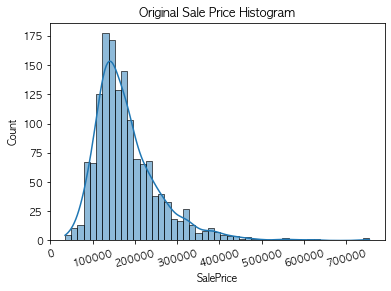

In [625]:
plt.title('Original Sale Price Histogram')
plt.xticks(rotation=15)
sns.histplot(house_df['SalePrice'], kde=True)
plt.show()

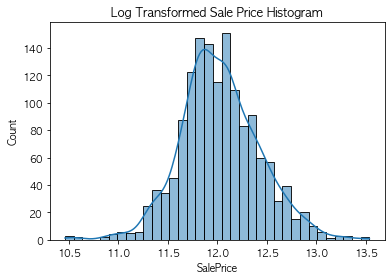

In [626]:
plt.title('Log Transformed Sale Price Histogram')
log_SalePrice = np.log1p(house_df['SalePrice'])
sns.histplot(log_SalePrice, kde=True)
plt.show()

In [627]:
# SalePrice 로그 변환
original_SalePrice = house_df['SalePrice']
house_df['SalePrice'] = np.log1p(house_df['SalePrice'])

# Null 이 너무 많은 컬럼들과 불필요한 컬럼 삭제
house_df.drop(['Id','PoolQC' , 'MiscFeature', 'Alley', 'Fence','FireplaceQu'], axis=1 , inplace=True)
# Drop 하지 않는 숫자형 Null컬럼들은 평균값으로 대체
house_df.fillna(house_df.mean(),inplace=True)

# Null 값이 있는 피처명과 타입을 추출
null_column_count = house_df.isnull().sum()[house_df.isnull().sum() > 0]
print('## Null 피처의 Type :\n', house_df.dtypes[null_column_count.index])

## Null 피처의 Type :
 MasVnrType      object
BsmtQual        object
BsmtCond        object
BsmtExposure    object
BsmtFinType1    object
BsmtFinType2    object
Electrical      object
GarageType      object
GarageFinish    object
GarageQual      object
GarageCond      object
dtype: object


In [628]:
from scipy.stats import skew

In [629]:
# object가 아닌 숫자형 피처의 칼럼 index 객체 추출.
features_index = house_df.dtypes[house_df.dtypes != 'object'].index

# house_df에 칼럼 index를 [ ]로 입력하면 해당하는 칼럼 데이터 세트 반환. apply lambda로 skew()호출
skew_features = house_df[features_index].apply(lambda x : skew(x))

# skew(왜곡) 정도가 1 이상인 칼럼만 추출.
skew_features_top = skew_features[skew_features > 1]
print(skew_features_top.sort_values(ascending=False))

MiscVal          24.451640
PoolArea         14.813135
LotArea          12.195142
3SsnPorch        10.293752
LowQualFinSF      9.002080
KitchenAbvGr      4.483784
BsmtFinSF2        4.250888
ScreenPorch       4.117977
BsmtHalfBath      4.099186
EnclosedPorch     3.086696
MasVnrArea        2.673661
LotFrontage       2.382499
OpenPorchSF       2.361912
BsmtFinSF1        1.683771
WoodDeckSF        1.539792
TotalBsmtSF       1.522688
MSSubClass        1.406210
1stFlrSF          1.375342
GrLivArea         1.365156
dtype: float64


In [630]:
house_df[skew_features_top.index] = np.log1p(house_df[skew_features_top.index])

In [631]:
# One-hot encoding
print('get_dummies() 수행 전 데이터 Shape:', house_df.shape)
house_df_ohe = pd.get_dummies(house_df)
print('get_dummies() 수행 후 데이터 Shape:', house_df_ohe.shape)

null_column_count = house_df_ohe.isnull().sum()[house_df_ohe.isnull().sum() > 0]
print('## Null 피처의 Type :\n', house_df_ohe.dtypes[null_column_count.index])

get_dummies() 수행 전 데이터 Shape: (1460, 75)
get_dummies() 수행 후 데이터 Shape: (1460, 271)
## Null 피처의 Type :
 Series([], dtype: object)


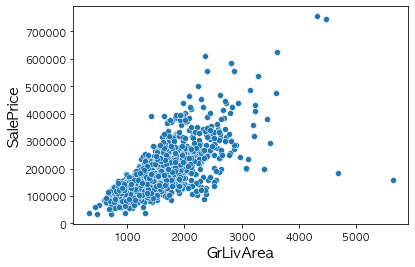

In [632]:
# Outlier 확인
sns.scatterplot(x=house_df_org['GrLivArea'], y=house_df_org['SalePrice'])
plt.ylabel('SalePrice', fontsize=15)
plt.xlabel('GrLivArea', fontsize=15)
plt.show()

In [633]:
# GrLivArea와 SalePrice 모두 로그 변환되었으므로 이를 반영한 조건 생성. 
cond1 = house_df_ohe['GrLivArea'] > np.log1p(4000)
cond2 = house_df_ohe['SalePrice'] < np.log1p(500000)
outlier_index = house_df_ohe[cond1 & cond2].index

print('아웃라이어 레코드 index :', outlier_index.values)
print('아웃라이어 삭제 전 house_df_ohe shape:', house_df_ohe.shape)

# DataFrame의 index를 이용하여 아웃라이어 레코드 삭제. 
house_df_ohe.drop(outlier_index , axis=0, inplace=True)
print('아웃라이어 삭제 후 house_df_ohe shape:', house_df_ohe.shape)

아웃라이어 레코드 index : [ 523 1298]
아웃라이어 삭제 전 house_df_ohe shape: (1460, 271)
아웃라이어 삭제 후 house_df_ohe shape: (1458, 271)


In [634]:
y = house_df_ohe['SalePrice']
x = house_df_ohe.drop('SalePrice', axis=1, inplace=False)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=156)

In [635]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso

In [636]:
ridge_params = {'alpha': [0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]}
lasso_params = {'alpha': [0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1,5, 10]}

grid_model = GridSearchCV(ridge_reg, param_grid=ridge_params, scoring='neg_mean_squared_error', cv=5)
grid_model.fit(x, y)
rmse = np.sqrt(-1 * grid_model.best_score_)
print('{0} 5 CV 시 최적 평균 RMSE 값: {1}, 최적 alpha:{2}'.format(model.__class__.__name__, np.round(rmse, 4), grid_model.best_params_))
best_ridge = grid_model.best_estimator_

grid_model = GridSearchCV(lasso_reg, param_grid=lasso_params, scoring='neg_mean_squared_error', cv=5)
grid_model.fit(x, y)
rmse = np.sqrt(-1 * grid_model.best_score_)
print('{0} 5 CV 시 최적 평균 RMSE 값: {1}, 최적 alpha:{2}'.format(model.__class__.__name__, np.round(rmse, 4), grid_model.best_params_))
best_lasso = grid_model.best_estimator_

LGBMRegressor 5 CV 시 최적 평균 RMSE 값: 0.1125, 최적 alpha:{'alpha': 8}
LGBMRegressor 5 CV 시 최적 평균 RMSE 값: 0.1122, 최적 alpha:{'alpha': 0.001}


In [637]:
# 앞 예제에서 학습한 lr_reg, ridge_reg, lasso_reg 모델의 CV RMSE값 출력           
models = [lr_reg, ridge_reg, lasso_reg]
for model in models:
    # 분할하지 않고 전체 데이터로 cross_val_score( ) 수행. 모델별 CV RMSE값과 평균 RMSE 출력
    rmse_list = np.sqrt(-cross_val_score(model, x, y, scoring="neg_mean_squared_error", cv=5))
    rmse_avg = np.mean(rmse_list)
    print('\n{0} CV RMSE 값 리스트: {1}'.format( model.__class__.__name__, np.round(rmse_list, 3)))
    print('{0} CV 평균 RMSE 값: {1}'.format( model.__class__.__name__, np.round(rmse_avg, 3)))


LinearRegression CV RMSE 값 리스트: [0.115 0.128 0.142 0.113 0.118]
LinearRegression CV 평균 RMSE 값: 0.123

Ridge CV RMSE 값 리스트: [0.103 0.119 0.122 0.105 0.114]
Ridge CV 평균 RMSE 값: 0.112

Lasso CV RMSE 값 리스트: [0.131 0.144 0.146 0.139 0.142]
Lasso CV 평균 RMSE 값: 0.141


LinearRegression 로그 변환된 RMSE: 0.129
Ridge 로그 변환된 RMSE: 0.103
Lasso 로그 변환된 RMSE: 0.1


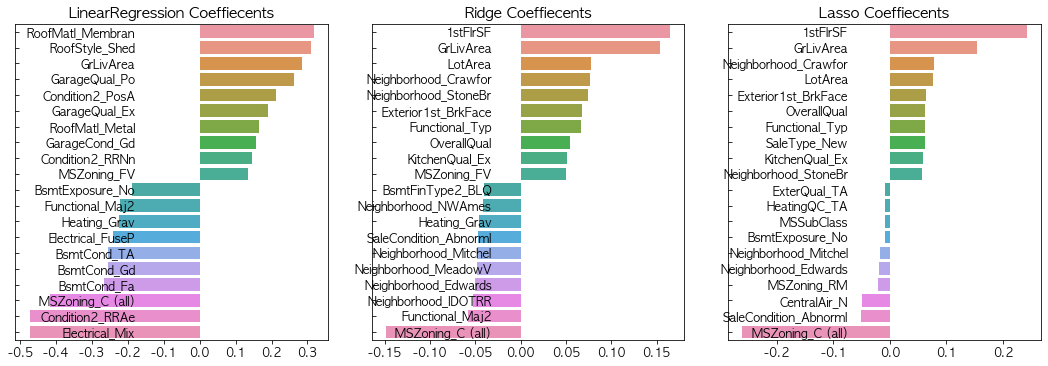

In [638]:
# 앞의 최적화 alpha값으로 학습데이터로 학습, 테스트 데이터로 예측 및 평가 수행. 
lr_reg = LinearRegression()
lr_reg.fit(x_train, y_train)

ridge_reg = Ridge(alpha=10)
ridge_reg.fit(x_train, y_train)

lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(x_train, y_train)

# 모든 모델의 RMSE 출력
models = [lr_reg, ridge_reg, lasso_reg]

rmses = []
for model in models:
    pred = model.predict(x_test)
    rmse = mean_squared_error(y_test, pred, squared=False)

    print('{0} 로그 변환된 RMSE: {1}'.format(model.__class__.__name__,np.round(rmse, 3)))
    rmses.append(rmse)

# 모든 모델의 회귀 계수 시각화 
models = [lr_reg, ridge_reg, lasso_reg]

# 3개 회귀 모델의 시각화를 위해 3개의 컬럼을 가지는 subplot 생성
fig, axs = plt.subplots(figsize=(15, 5), nrows=1, ncols=3)
fig.tight_layout() 
# 입력인자로 받은 list객체인 models에서 차례로 model을 추출하여 회귀 계수 시각화. 
for i_num, model in enumerate(models): 
    # coef_ 속성을 기반으로 Series 객체를 생성. index는 컬럼명. 
    coef = pd.Series(model.coef_, index=x.columns)

    # 상위 10개, 하위 10개 coefficient 추출
    coef_high = coef.sort_values(ascending=False).head(10)
    coef_low = coef.sort_values(ascending=False).tail(10)
        
    coef_concat = pd.concat( [coef_high , coef_low] )
    # 순차적으로 ax subplot에 barchar로 표현. 한 화면에 표현하기 위해 tick label 위치와 font 크기 조정. 
    axs[i_num].set_title(model.__class__.__name__+' Coeffiecents', size=15)
    axs[i_num].tick_params(axis="y",direction="in", pad=-120)
    for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
        label.set_fontsize(12)
    sns.barplot(x=coef_concat.values, y=coef_concat.index, ax=axs[i_num])

In [639]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [ ]:
xgb_params = {'n_estimators':[100]}
xgb_reg = XGBRegressor(n_estimators=100, learning_rate=0.05, colsample_bytree=0.5, subsample=0.8)
grid_model = GridSearchCV(xgb_reg, param_grid=xgb_params, scoring='neg_mean_squared_error', cv=5)
grid_model.fit(x, y)
rmse = np.sqrt(-1 * grid_model.best_score_)
print('{0} 5 CV 시 최적 평균 RMSE 값: {1}, 최적 alpha:{2}'.format(model.__class__.__name__, np.round(rmse, 4), grid_model.best_params_))
best_xgb = grid_model.best_estimator_

lgbm_params = {'n_estimators':[100]}
lgbm_reg = LGBMRegressor(n_estimators=100, learning_rate=0.05, num_leaves=4, subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)
grid_model = GridSearchCV(lgbm_reg, param_grid=lgbm_params, scoring='neg_mean_squared_error', cv=5)
grid_model.fit(x, y)
rmse = np.sqrt(-1 * grid_model.best_score_)
print('{0} 5 CV 시 최적 평균 RMSE 값: {1}, 최적 alpha:{2}'.format(model.__class__.__name__, np.round(rmse, 4), grid_model.best_params_))
best_lgbm = grid_model.best_estimator_

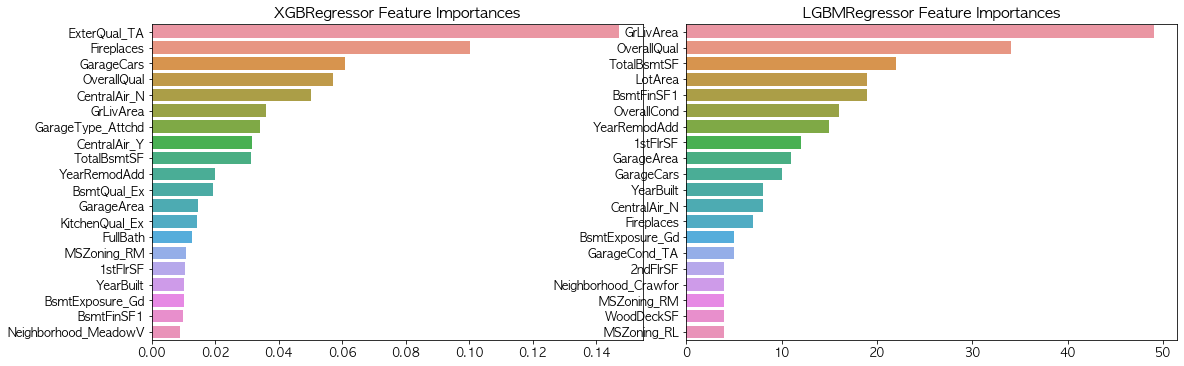

In [641]:
# 앞 예제에서 print_best_params()가 반환한 GridSearchCV로 최적화된 모델의 피처 중요도 시각화    
models = [best_xgb, best_lgbm]
fig, axs = plt.subplots(figsize=(15, 5), nrows=1, ncols=2)
fig.tight_layout() 

# 입력인자로 받은 list객체인 models에서 차례로 model을 추출하여 피처 중요도 시각화. 
for i_num, model in enumerate(models):
    # 중요도 상위 20개의 피처명과 그때의 중요도값 추출 
    ftr_importances_values = model.feature_importances_
    ftr_importances = pd.Series(ftr_importances_values, index=x.columns)
    ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]
    
    axs[i_num].set_title(model.__class__.__name__+' Feature Importances', size=15)
    #font 크기 조정.
    for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
        label.set_fontsize(12)
    sns.barplot(x=ftr_top20.values, y=ftr_top20.index , ax=axs[i_num])

In [642]:
# 개별 모델의 학습
ridge_reg = Ridge(alpha=10)
ridge_reg.fit(x_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(x_train, y_train)

xgb_reg = XGBRegressor(n_estimators=100, learning_rate=0.05, colsample_bytree=0.5, subsample=0.8)
lgbm_reg = LGBMRegressor(n_estimators=100, learning_rate=0.05, num_leaves=4, subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)
xgb_reg.fit(x_train, y_train)
lgbm_reg.fit(x_train, y_train)

# 개별 모델 예측
ridge_pred = ridge_reg.predict(x_test)
lasso_pred = lasso_reg.predict(x_test)
xgb_pred = xgb_reg.predict(x_test)
lgbm_pred = lgbm_reg.predict(x_test)

# 개별 모델 예측값 혼합으로 최종 예측값 도출
pred = 0.2 * ridge_pred + 0.2 * lasso_pred + 0.3 * xgb_pred + 0.3 * lgbm_pred
preds = {'최종 혼합': pred,
         'Ridge': ridge_pred,
         'Lasso': lasso_pred,
         'XGB': xgb_pred,
         'LGBM': lgbm_pred}

#최종 혼합 모델, 개별모델의 RMSE 값 출력
for key in preds.keys():
    print('{0} 모델의 RMSE: {1}'.format(key, mean_squared_error(y_test , preds[key], squared=False)))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001663 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3176
[LightGBM] [Info] Number of data points in the train set: 1166, number of used features: 173
[LightGBM] [Info] Start training from score 12.025343
최종 혼합 모델의 RMSE: 0.1070669560690982
Ridge 모델의 RMSE: 0.10313416607869504
Lasso 모델의 RMSE: 0.10024170460890018
XGB 모델의 RMSE: 0.142597652897906
LGBM 모델의 RMSE: 0.1259491105489445


In [643]:
# get_stacking_base_datasets()은 넘파이 ndarray를 인자로 사용하므로 DataFrame을 넘파이로 변환. 
x_train_n = x_train.values
x_test_n = x_test.values
y_train_n = y_train.values

# 각 개별 기반(Base)모델이 생성한 학습용/테스트용 데이터 반환. 
ridge_train, ridge_test = get_stacking_base_datasets(ridge_reg, x_train_n, y_train_n, x_test_n, 5)
lasso_train, lasso_test = get_stacking_base_datasets(lasso_reg, x_train_n, y_train_n, x_test_n, 5)
xgb_train, xgb_test = get_stacking_base_datasets(xgb_reg, x_train_n, y_train_n, x_test_n, 5)  
lgbm_train, lgbm_test = get_stacking_base_datasets(lgbm_reg, x_train_n, y_train_n, x_test_n, 5)

Ridge  model 시작
	 폴드 세트:  0  시작
	 폴드 세트:  1  시작
	 폴드 세트:  2  시작
	 폴드 세트:  3  시작
	 폴드 세트:  4  시작
Lasso  model 시작
	 폴드 세트:  0  시작
	 폴드 세트:  1  시작
	 폴드 세트:  2  시작
	 폴드 세트:  3  시작
	 폴드 세트:  4  시작
XGBRegressor  model 시작
	 폴드 세트:  0  시작
	 폴드 세트:  1  시작
	 폴드 세트:  2  시작
	 폴드 세트:  3  시작
	 폴드 세트:  4  시작
LGBMRegressor  model 시작
	 폴드 세트:  0  시작
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004243 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2926
[LightGBM] [Info] Number of data points in the train set: 932, number of used features: 157
[LightGBM] [Info] Start training from score 12.035561
	 폴드 세트:  1  시작
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002139 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2953
[LightGBM] [Info] Number of data points i

In [644]:
# 개별 모델이 반환한 학습 및 테스트용 데이터 세트를 Stacking 형태로 결합.  
stack_final_x_train = np.concatenate((ridge_train, lasso_train, xgb_train, lgbm_train), axis=1)
stack_final_x_test = np.concatenate((ridge_test, lasso_test, xgb_test, lgbm_test), axis=1)

# 최종 메타 모델은 라쏘 모델을 적용. 
meta_model_lasso = Lasso(alpha=0.0005)

#기반 모델의 예측값을 기반으로 새롭게 만들어진 학습 및 테스트용 데이터로 예측하고 RMSE 측정.
meta_model_lasso.fit(stack_final_x_train, y_train)
print('스태킹 회귀 모델의 최종 RMSE 값은:', mean_squared_error(y_test, meta_model_lasso.predict(stack_final_x_test), squared=False))

스태킹 회귀 모델의 최종 RMSE 값은: 0.09956333257374468
